In [1]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import Select

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import re
import networkx as nx
from collections import Counter
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import pycountry

### Введение. 

Мне всегда было интересно узнать, как люди формируют оценку просмотренного им фильма: какие критерии влияют на оценку; какие из них более важны; почему одни фильмы получают высокие оценки, а другие - нет; а также, можно ли предсказать, как в среднем люди оценивают фильмы. Именно в этом заключается цель моего проекта. Я посмотрю, как различные характеристики фильмов влияют на оценки зрителей, а потом попытаюсь предсказывать эти оценки на основе имеющихся характеристик. В качестве оценки я буду брать рейтинг фильма на Кинопоиске, основные характеристики фильма будут также взяты оттуда. Несмотря на то, что оценка фильма - довольно субъективная вещь, я склоняюсь к тому, что фильмы массовой культуры скорее оцениваюся людьми одинаково, поэтому можно попробовать с этими оценками что-то сделать. В течение работы выдвигается множество гипотез, связанных с конкретными характеристиками, а потом они подтверждаются или опровергаются. 

#### Техническая сторона проекта. 
В работе использован продвинутый скреппинг Selenium для сбора данных. Использовались продвинутые возможности pandas, регулярные выражения для обработки и анализа данных. В проекте есть работа с геоданными (geopandas), в том числе интерактивная карта, графы и интерактивные графы (библиотека networkx), различные визуализации данных, SQL для разбивки данных по группам для анализа, математические возможности (scipy stats для нормального распределения). В конце проекта запущены модели машинного обучения для предсказания рейтинга фильма на Кинопоиске по его характеристикам (catboost, lgbm, нейронная сеть). Были задействованы нетривиальные библиотеки (optuna, torch и т.д.). 

#### Характеристики используемых датасетов.
1) kino_all_first_5000.csv 

Колонки: 'Название фильма', 'Название фильма на анг', 'Ссылка' - ссылка на страницу фильма на Кинопоиске, 'Режиссер', 'Страна', 'Год выпуска', 'Жанры', 'Актеры' - два основных актера в фильме, 'Продолжительность', 'Рейтинг' - оценка, выставленная на Кинопоиске, 'Количество Оценок' - количество людей, оценивших фильм на Кинопоиске.

Источник данных: Кинопоиск, https://www.kinopoisk.ru/lists/movies/?b=films&

2) kino_all_first_5000_processed.csv

Колонки: 'Название фильма', 'Название фильма на анг', 'Ссылка', 'Режиссер', 'Страна', 'Год выпуска', 'Жанры', 'Продолжительность', 'Рейтинг', 'Количество Оценок', 'Актер 1' - первый актер из пары в предыдущем датасете, 'Актер 2' - второй актер из пары в предыдущем датасете, 'Оскар у режиссера' - количество номинаций на Оскар у режиссера, 'Оскар у актеров' - количество номинаций на Оскар у двух актеров суммарно.

Источники данных: Кинопоиск, https://www.kinopoisk.ru/lists/movies/?b=films&;

Википедия, https://ru.wikipedia.org/wiki/Премия_«Оскар»_за_лучшую_режиссуру,

https://ru.wikipedia.org/wiki/Премия_«Оскар»_за_лучшую_женскую_роль,

https://ru.wikipedia.org/wiki/Премия_«Оскар»_за_лучшую_мужскую_роль

##### О работе много написано в комментариях в разных разделах. Прошу обратить на них внимание (не стала выносить все в введение).

## 1. Сбор данных

Данные я запарсила с основной страницы Кинопоиска, взяв первые 5000 фильмов (100 страниц сайта Кинопоиск). Если изучить данную страницу Кинопоиска, то можно заметить, что фильмы расположены скорее в порядке популярности, а не по рейтингу. Благодаря этому анализ будет лучше, потому что на неизвестные фильмы особо нет смысла смотреть, но и при этом нет сильного смещения в хорошие фильмы (такое бы было, если бы я парсила список лучших фильмов, отсортированных по рейтингу). Также стоит отметить, что 5000 фильмов - довольно много и поэтому должно быть репрезентативно. 

Парсинг был не самый простой, так как на странице периодически вылезала капча (код, который нажимал на капчу, сейчас закомментирован). Также нужно было разделять данные по колонкам самостоятельно, так как в одной строчке содержалось сразу много информации о фильме. Код можно запустить, чтобы проверить его работу, так как данные далее были сохранены в csv и потом можно загрузить их оттуда.

In [4]:
df = pd.DataFrame(columns=['Название фильма', 'Название фильма на анг', 'Ссылка', 'Режиссер', 'Страна', 'Год выпуска', 'Жанры', 'Актеры', 'Продолжительность', 'Рейтинг', 'Количество Оценок'])

In [19]:
service = Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)

for page in range(91, 101):
    url_ = f'https://www.kinopoisk.ru/lists/movies/?b=films&page={page}'
    driver.get(url_)

    #time.sleep(10)
    #try:
    #    button = driver.find_element(By.XPATH, '//*[@id="js-button"]')
    #    button.click()
    #except NoSuchElementException:
    #    continue
    time.sleep(20)

    title_elements = driver.find_elements(By.CLASS_NAME, 'styles_mainTitle__IFQyZ')
    titles = [element.text for element in title_elements]

    link_elements = driver.find_elements(By.CLASS_NAME, 'base-movie-main-info_link__YwtP1')
    links = [element.get_attribute('href') for element in link_elements if element.get_attribute('href') is not None]

    info_elements = driver.find_elements(By.CLASS_NAME, 'desktop-list-main-info_secondaryTitleSlot__mc0mI')
    info = [element.text for element in info_elements]
    titles_eng = []
    years = []
    durations = []

    for movie in info:
        if '\n, ' in movie:
            parts = movie.split('\n, ')
            title = parts[0]
            if ', ' in parts[1]:
                year, duration = parts[1].split(', ')
                duration = duration.replace(' мин.', '')
            else:
                year = parts[1]
                duration = None
        else:
            title = None
            if ', ' in movie:
                year, duration = movie.split(', ')
                duration = duration.replace(' мин.', '')
            else:
                year = movie
                duration = None
        
        titles_eng.append(title)
        years.append(year)
        durations.append(duration)

    dir_elements = driver.find_elements(By.CLASS_NAME, 'desktop-list-main-info_additionalInfo__Hqzof')
    dir = [element.text for element in dir_elements]

    countries = []
    genres = []
    directors = []
    actors = []
    i = 0
    while i < len(dir):
        part1 = dir[i].split('  Режиссёр: ')
        country_genre = part1[0].split(' • ')
        country = country_genre[0]
        genre = country_genre[1] if len(country_genre) > 1 else None
        director = part1[1] if len(part1) > 1 else None

        if i < len(dir) - 1:
            part2 = dir[i + 1].replace('В ролях: ', '') if 'В ролях: ' in dir[i + 1] else None
            if 'В ролях: ' not in dir[i + 1]:
                i += 1
            else:
                i += 2
        else:
            part2 = None
            i += 1

        countries.append(country)
        genres.append(genre)
        directors.append(director)
        actors.append(part2)

    rate_elements = driver.find_elements(By.CLASS_NAME, 'styles_kinopoiskValueBlock__d0RBQ')
    rate = [element.text for element in rate_elements]

    num_elements = driver.find_elements(By.CLASS_NAME, 'styles_kinopoiskCount__PT7ZX')
    num = [element.text for element in num_elements]

    temp_df = pd.DataFrame({
        'Название фильма': titles,
        'Название фильма на анг': titles_eng,
        'Ссылка': links,  
        'Режиссер': directors,
        'Страна': countries,
        'Год выпуска': years,
        'Жанры': genres,
        'Актеры': actors,
        'Продолжительность': durations,
        'Рейтинг': rate,
        'Количество Оценок': num
    })

    df = pd.concat([df, temp_df], ignore_index=True)

In [20]:
df

,Название фильма,Название фильма на анг,Ссылка,Режиссер,Страна,Год выпуска,Жанры,Актеры,Продолжительность,Рейтинг,Количество Оценок
0,1+1,Intouchables,https://www.kinopoisk.ru/film/535341/,Оливье Накаш,Франция,2011,драма,"Франсуа Клюзе, Омар Си",112.0,8.8,2 115K
1,Джентльмены,The Gentlemen,https://www.kinopoisk.ru/film/1143242/,Гай Ричи,США,2019,криминал,"Мэттью Макконахи, Чарли Ханнэм",113.0,8.6,1 809K
2,Волк с Уолл-стрит,The Wolf of Wall Street,https://www.kinopoisk.ru/film/462682/,Мартин Скорсезе,США,2013,драма,"Леонардо ДиКаприо, Джона Хилл",180.0,8.0,1 389K
3,Брат,NaN,https://www.kinopoisk.ru/film/41519/,Алексей Балабанов,Россия,1997,драма,"Сергей Бодров мл., Виктор Сухоруков",100.0,8.3,1 388K
4,Гнев человеческий,Wrath of Man,https://www.kinopoisk.ru/film/1318972/,Гай Ричи,Великобритания,2021,боевик,"Джейсон Стэйтем, Холт Маккэллани",119.0,7.6,1 327K
...,...,...,...,...,...,...,...,...,...,...,...
4995,Мечта Кассандры,Cassandra's Dream,https://www.kinopoisk.ru/film/255368/,Вуди Аллен,Великобритания,2007,триллер,"Юэн Макгрегор, Колин Фаррелл",108,7.0,26 043
4996,Мгновения Нью-Йорка,New York Minute,https://www.kinopoisk.ru/film/32034/,Дэнни Гордон,США,2004,мелодрама,"Эшли Олсен, Мэри-Кейт Олсен",91,6.8,26 038
4997,Мирай из будущего,Mirai no Mirai,https://www.kinopoisk.ru/film/1045331/,Мамору Хосода,Япония,2018,аниме,"Мока Камисираиси, Хару Куроки",98,7.2,26 037
4998,Страна приливов,Tideland,https://www.kinopoisk.ru/film/81598/,Терри Гиллиам,Великобритания,2005,драма,"Джоделль Ферланд, Джефф Бриджес",122,6.9,26 034


In [21]:
df.to_csv('kino_all_first_5000.csv', index=False, encoding='utf-8')

## 2. Предобработка данных
На этом основный парсинг закончен. Теперь выгружаем этот датасет уже для работы с данными, посмотрим на него повнимательнее.

In [4]:
df = pd.read_csv('kino_all_first_5000.csv', encoding='utf-8')
df

,Название фильма,Название фильма на анг,Ссылка,Режиссер,Страна,Год выпуска,Жанры,Актеры,Продолжительность,Рейтинг,Количество Оценок
0,1+1,Intouchables,https://www.kinopoisk.ru/film/535341/,Оливье Накаш,Франция,2011,драма,"Франсуа Клюзе, Омар Си",112.0,8.8,2 115K
1,Джентльмены,The Gentlemen,https://www.kinopoisk.ru/film/1143242/,Гай Ричи,США,2019,криминал,"Мэттью Макконахи, Чарли Ханнэм",113.0,8.6,1 809K
2,Волк с Уолл-стрит,The Wolf of Wall Street,https://www.kinopoisk.ru/film/462682/,Мартин Скорсезе,США,2013,драма,"Леонардо ДиКаприо, Джона Хилл",180.0,8.0,1 389K
3,Брат,NaN,https://www.kinopoisk.ru/film/41519/,Алексей Балабанов,Россия,1997,драма,"Сергей Бодров мл., Виктор Сухоруков",100.0,8.3,1 388K
4,Гнев человеческий,Wrath of Man,https://www.kinopoisk.ru/film/1318972/,Гай Ричи,Великобритания,2021,боевик,"Джейсон Стэйтем, Холт Маккэллани",119.0,7.6,1 327K
...,...,...,...,...,...,...,...,...,...,...,...
4995,Мечта Кассандры,Cassandra's Dream,https://www.kinopoisk.ru/film/255368/,Вуди Аллен,Великобритания,2007,триллер,"Юэн Макгрегор, Колин Фаррелл",108.0,7.0,26 043
4996,Мгновения Нью-Йорка,New York Minute,https://www.kinopoisk.ru/film/32034/,Дэнни Гордон,США,2004,мелодрама,"Эшли Олсен, Мэри-Кейт Олсен",91.0,6.8,26 038
4997,Мирай из будущего,Mirai no Mirai,https://www.kinopoisk.ru/film/1045331/,Мамору Хосода,Япония,2018,аниме,"Мока Камисираиси, Хару Куроки",98.0,7.2,26 037
4998,Страна приливов,Tideland,https://www.kinopoisk.ru/film/81598/,Терри Гиллиам,Великобритания,2005,драма,"Джоделль Ферланд, Джефф Бриджес",122.0,6.9,26 034


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Название фильма         5000 non-null   object 
 1   Название фильма на анг  4017 non-null   object 
 2   Ссылка                  5000 non-null   object 
 3   Режиссер                4999 non-null   object 
 4   Страна                  5000 non-null   object 
 5   Год выпуска             5000 non-null   int64  
 6   Жанры                   5000 non-null   object 
 7   Актеры                  4977 non-null   object 
 8   Продолжительность       4993 non-null   float64
 9   Рейтинг                 5000 non-null   float64
 10  Количество Оценок       5000 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 429.8+ KB


Заполнять пропуски тут не будем, так как они тут по объяснимым причинам: 1) фильм русский - нет названия на английском; 2) это мультик/документалка/что-то странное - нет режиссера или актеров; 3) просто какой-то странный случай, нет изначально данных у Кинопоиска.

Вместо этого обработаем некоторые колонки - переведем количество оценок в числа, разобъем актеров из пар по колонкам.

In [6]:
def convert_ratings(rating):
    rating = str(rating).replace(" ", '')
    if 'K' in rating:
        return int(rating.replace('K', '000'))
    return int(rating)
df['Количество Оценок'] = df['Количество Оценок'].apply(convert_ratings)

def split_actors(actors):
    if pd.isna(actors):
        return pd.Series([np.nan, np.nan])
    if ", " in actors:
        actor1, actor2 = actors.split(', ')
    else:
        actor1, actor2 = actors, None
    return pd.Series([actor1, actor2])

df[['Актер 1', 'Актер 2']] = df['Актеры'].apply(split_actors)
df.drop(columns=['Актеры'], inplace=True)

df

,Название фильма,Название фильма на анг,Ссылка,Режиссер,Страна,Год выпуска,Жанры,Продолжительность,Рейтинг,Количество Оценок,Актер 1,Актер 2
0,1+1,Intouchables,https://www.kinopoisk.ru/film/535341/,Оливье Накаш,Франция,2011,драма,112.0,8.8,2115000,Франсуа Клюзе,Омар Си
1,Джентльмены,The Gentlemen,https://www.kinopoisk.ru/film/1143242/,Гай Ричи,США,2019,криминал,113.0,8.6,1809000,Мэттью Макконахи,Чарли Ханнэм
2,Волк с Уолл-стрит,The Wolf of Wall Street,https://www.kinopoisk.ru/film/462682/,Мартин Скорсезе,США,2013,драма,180.0,8.0,1389000,Леонардо ДиКаприо,Джона Хилл
3,Брат,NaN,https://www.kinopoisk.ru/film/41519/,Алексей Балабанов,Россия,1997,драма,100.0,8.3,1388000,Сергей Бодров мл.,Виктор Сухоруков
4,Гнев человеческий,Wrath of Man,https://www.kinopoisk.ru/film/1318972/,Гай Ричи,Великобритания,2021,боевик,119.0,7.6,1327000,Джейсон Стэйтем,Холт Маккэллани
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Мечта Кассандры,Cassandra's Dream,https://www.kinopoisk.ru/film/255368/,Вуди Аллен,Великобритания,2007,триллер,108.0,7.0,26043,Юэн Макгрегор,Колин Фаррелл
4996,Мгновения Нью-Йорка,New York Minute,https://www.kinopoisk.ru/film/32034/,Дэнни Гордон,США,2004,мелодрама,91.0,6.8,26038,Эшли Олсен,Мэри-Кейт Олсен
4997,Мирай из будущего,Mirai no Mirai,https://www.kinopoisk.ru/film/1045331/,Мамору Хосода,Япония,2018,аниме,98.0,7.2,26037,Мока Камисираиси,Хару Куроки
4998,Страна приливов,Tideland,https://www.kinopoisk.ru/film/81598/,Терри Гиллиам,Великобритания,2005,драма,122.0,6.9,26034,Джоделль Ферланд,Джефф Бриджес


Не совсем понятно, как работать с признаками режиссер и актеры, так как разных режиссеров и актеров очень много и тогда непонятно, как конкретный актер или режиссер влияет на оценку. Самое простое решение - посмотрим на самую популярную премию в сфере кино - Оскар. Среплю данные из википедии по номинациям Лучшая режиссура, Лучшая женская роль и Лучшая мужская роль и считаю количество **номинаций** у всех режиссеров и актеров, далее сопоставляю их с исходными данными и записываю в датафрейм количество номинаций у режиссера и сумму номинаций актеров. 

Возникает несколько вопросов:
1) Почему номинации, а не только победы? Потому что во время Оскара у людей на слуху все номинанты, соответсвенно растет популярность/репутация фильмов с этими героями. И потом уже никому не важно, кто победил (и не совсем понятно, как выбирается победитель). Люди скорее обращают внимание на всех номинированных.
2) Почему не обращаю внимание на время, когда герой был номинирован на Оскар? Тут я думаю, что это тоже не важно. Если человека номинировали на премию, то возрастет популярность как новых фильмов (после Оскара), так и старых фильмов героя. Люди будут смотреть фильмы уже зная, что герой хорош, и могут ставить ему выше оценки. Плюс никто не отменяет талант героя, который как был до премии Оскар (и он просто подтвердился), так и после. Поэтому не важно, фильм был снят до или после номинации на Оскар.

In [7]:
service = Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)

url_ = 'https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BC%D0%B8%D1%8F_%C2%AB%D0%9E%D1%81%D0%BA%D0%B0%D1%80%C2%BB_%D0%B7%D0%B0_%D0%BB%D1%83%D1%87%D1%88%D1%83%D1%8E_%D1%80%D0%B5%D0%B6%D0%B8%D1%81%D1%81%D1%83%D1%80%D1%83'
driver.get(url_)

time.sleep(20)

info = driver.find_elements(By.CLASS_NAME, 'wikitable')
info = [element.text for element in info]
info = info[2:-1]
info

['Церемония Фото лауреата Режиссёр Фильм\n13-я (1941)\n• Джон Форд «Гроздья гнева»\n• Сэм Вуд «Китти Фойл»\n• Уильям Уайлер «Письмо»\n• Джордж Кьюкор «Филадельфийская история»\n• Альфред Хичкок «Ребекка»\n14-я (1942)\n• Джон Форд «Как зелена была моя долина»\n• Орсон Уэллс «Гражданин Кейн»\n• Александр Холл «А вот и мистер Джордан»\n• Уильям Уайлер «Маленькие лисички»\n• Говард Хоукс «Сержант Йорк»\n15-я (1943)\n• Уильям Уайлер «Миссис Минивер»\n• Сэм Вуд «Кингс Роу»\n• Мервин Лерой «Случайная жатва»\n• Джон Фэрроу «Остров Уэйк»\n• Майкл Кёртис «Янки Дудл Денди»\n16-я (1944)\n• Майкл Кёртис «Касабланка»\n• Эрнст Любич «Небеса могут подождать»\n• Кларенс Браун «Человеческая комедия»\n• Джордж Стивенс «Чем больше, тем веселее»\n• Генри Кинг «Песня Бернадетт»\n17-я (1945)\n• Лео Маккэри «Идти своим путём»\n• Билли Уайлдер «Двойная страховка»\n• Отто Премингер «Лора»\n• Альфред Хичкок «Спасательная шлюпка»\n• Генри Кинг «Вильсон»\n18-я (1946)\n• Билли Уайлдер «Потерянный уикэнд»\n• Лео Мак

Использую регулярные выражения, чтобы сделать из таблицы Википедии список режиссеров и актеров, номинировавшихся на Оскар

In [8]:
oscar_directors = []

for data in info:
    lines = data.split('\n')

    regex = r'• ([\w\s\.\,\[\]]+) «'

    for line in lines:

        match = re.search(regex, line)
        if match:
            director = match.group(1).strip()
            oscar_directors.append(director)

Функции, чтобы убрать все лишнее от имен и посчитать количество номинаций

In [9]:
def clean_and_split_names(names_list):
    cleaned = []
    for name in names_list:
        name = re.sub(r'\[\d+\]', '', name).strip()
        names = re.split(r'\sи\s|,\s*', name)
        cleaned.extend(names)
    return [name.strip() for name in cleaned]

def count_oscars(name, nomination):
    return nomination.count(name)

Колонка в датафрейме называется Оскар у режиссера для краткости (помним, что это номинации, а не сами Оскары).

In [10]:
oscar_directors = clean_and_split_names(oscar_directors)
df['Оскар у режиссера'] = df['Режиссер'].apply(lambda director: count_oscars(director, oscar_directors))
df

,Название фильма,Название фильма на анг,Ссылка,Режиссер,Страна,Год выпуска,Жанры,Продолжительность,Рейтинг,Количество Оценок,Актер 1,Актер 2,Оскар у режиссера
0,1+1,Intouchables,https://www.kinopoisk.ru/film/535341/,Оливье Накаш,Франция,2011,драма,112.0,8.8,2115000,Франсуа Клюзе,Омар Си,0
1,Джентльмены,The Gentlemen,https://www.kinopoisk.ru/film/1143242/,Гай Ричи,США,2019,криминал,113.0,8.6,1809000,Мэттью Макконахи,Чарли Ханнэм,0
2,Волк с Уолл-стрит,The Wolf of Wall Street,https://www.kinopoisk.ru/film/462682/,Мартин Скорсезе,США,2013,драма,180.0,8.0,1389000,Леонардо ДиКаприо,Джона Хилл,10
3,Брат,NaN,https://www.kinopoisk.ru/film/41519/,Алексей Балабанов,Россия,1997,драма,100.0,8.3,1388000,Сергей Бодров мл.,Виктор Сухоруков,0
4,Гнев человеческий,Wrath of Man,https://www.kinopoisk.ru/film/1318972/,Гай Ричи,Великобритания,2021,боевик,119.0,7.6,1327000,Джейсон Стэйтем,Холт Маккэллани,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Мечта Кассандры,Cassandra's Dream,https://www.kinopoisk.ru/film/255368/,Вуди Аллен,Великобритания,2007,триллер,108.0,7.0,26043,Юэн Макгрегор,Колин Фаррелл,7
4996,Мгновения Нью-Йорка,New York Minute,https://www.kinopoisk.ru/film/32034/,Дэнни Гордон,США,2004,мелодрама,91.0,6.8,26038,Эшли Олсен,Мэри-Кейт Олсен,0
4997,Мирай из будущего,Mirai no Mirai,https://www.kinopoisk.ru/film/1045331/,Мамору Хосода,Япония,2018,аниме,98.0,7.2,26037,Мока Камисираиси,Хару Куроки,0
4998,Страна приливов,Tideland,https://www.kinopoisk.ru/film/81598/,Терри Гиллиам,Великобритания,2005,драма,122.0,6.9,26034,Джоделль Ферланд,Джефф Бриджес,0


То же самое делаем с актерами

In [11]:
service = Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)

url_ = 'https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BC%D0%B8%D1%8F_%C2%AB%D0%9E%D1%81%D0%BA%D0%B0%D1%80%C2%BB_%D0%B7%D0%B0_%D0%BB%D1%83%D1%87%D1%88%D1%83%D1%8E_%D0%B6%D0%B5%D0%BD%D1%81%D0%BA%D1%83%D1%8E_%D1%80%D0%BE%D0%BB%D1%8C'
driver.get(url_)

time.sleep(20)

info = driver.find_elements(By.CLASS_NAME, 'wikitable')
info = [element.text for element in info]
info = info[2:]
info

['Церемония Фото лауреата Актриса Фильм Роль\n13-я (1941)\n• Джинджер Роджерс «Китти Фойл» Китти Фойл\n• Бетт Дейвис «Письмо» Лесли Кросби\n• Джоан Фонтейн «Ребекка» миссис де Винтер\n• Кэтрин Хепбёрн «Филадельфийская история» Трейси Лорд\n• Марта Скотт «Наш городок» Эмили Уэбб\n14-я (1942)\n• Джоан Фонтейн «Подозрение» Лина Маклэйдлоу\n• Бетт Дейвис «Маленькие лисички» Регина Гидденс\n• Оливия де Хэвилленд «Задержите рассвет» Эмми Браун\n• Грир Гарсон «Цветы в пыли» Эдна Кали Гледни\n• Барбара Стэнвик «С огоньком» Кэтрин О’Ши\n15-я (1943)\n• Грир Гарсон «Миссис Минивер» миссис Кей Минивер\n• Бетт Дейвис «Вперёд, путешественник» Шарлотта Вэйл\n• Кэтрин Хепбёрн «Женщина года» Тесс Хардинг\n• Розалинд Расселл «Моя сестра Эйлин» Рут Шервуд\n• Тереза Райт «Гордость янки» Элеонор Твитчелл Гериг\n16-я (1944)\n• Дженнифер Джонс «Песня Бернадетт» Бернадетта Субиру\n• Джин Артур «Чем больше, тем веселее» Констанс «Конни» Миллиган\n• Ингрид Бергман «По ком звонит колокол» Мария\n• Джоан Фонтейн 

In [12]:
actresses = []
for data in info:
    lines = data.split('\n')

    actor_regex = r'• ([^«]+) «[^»]+» [^«]+'

    for line in lines:
        match = re.match(actor_regex, line)
        if match:
            actress_name = match.group(1).strip()
            actresses.append(actress_name)

In [13]:
service = Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)

url_ = 'https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BC%D0%B8%D1%8F_%C2%AB%D0%9E%D1%81%D0%BA%D0%B0%D1%80%C2%BB_%D0%B7%D0%B0_%D0%BB%D1%83%D1%87%D1%88%D1%83%D1%8E_%D0%BC%D1%83%D0%B6%D1%81%D0%BA%D1%83%D1%8E_%D1%80%D0%BE%D0%BB%D1%8C'
driver.get(url_)

time.sleep(20)

info = driver.find_elements(By.CLASS_NAME, 'wikitable')
info = [element.text for element in info]
info = info[2:]
info

['Церемония Фото лауреата Актёр Фильм Роль\n13-я (1941)\n★ Джеймс Стюарт «Филадельфийская история» Макколи Коннор\n• Рэймонд Мэсси «Эйб Линкольн в Иллинойсе» Авраам Линкольн\n• Лоренс Оливье «Ребекка» Джордж Фортескью Максимилиан де Винтер\n• Генри Фонда «Гроздья гнева» Том Джоуд\n• Чарли Чаплин «Великий диктатор» Аденоид Хинкель / еврейский цирюльник\n14-я (1942)\n★ Гэри Купер «Сержант Йорк» Элвин К. Йорк\n• Кэри Грант «Грошовая серенада» Роджер Адамс\n• Роберт Монтгомери «А вот и мистер Джордан» Джо Пендлтон\n• Орсон Уэллс «Гражданин Кейн» Чарльз Фостер Кейн\n• Уолтер Хьюстон «Дьявол и Дэниэл Уэбстер» мистер Скрэтч\n15-я (1943)\n★ Джеймс Кэгни «Янки Дудл Денди» Джордж М. Коэн\n• Монти Вулли «Крысолов» Говард\n• Рональд Колман «Случайная жатва» Чарльз Рэйньер\n• Гэри Купер «Гордость янки» Лу Гериг\n• Уолтер Пиджон «Миссис Минивер» Клем Минивер\n16-я (1944)\n★ Пол Лукас «Дозор на Рейне» Курт Мюллер\n• Хамфри Богарт «Касабланка» Рик Блейн\n• Гэри Купер «По ком звонит колокол» Роберт Джо

In [14]:
actors = []
for data in info:
    lines = data.split('\n')

    actor_regex = r'•?\s*★?\s*([^«]+?)\s*(?:\[.*?\])?\s*«'

    for line in lines:
        match = re.search(actor_regex, line)
        if match:
            actor_name = match.group(1).strip()
            actors.append(actor_name)

Имена мэтчатся с именами из нашего датафрейма у всех, кроме любимого Лео(( пришлось ручками поменять

In [15]:
actors = ['Леонардо ДиКаприо' if x == 'Леонардо Ди Каприо' else x for x in actors]

Добавляем номинации для актеров

In [16]:
actors_oscars = actors + actresses
df['Оскар у актеров'] = df['Актер 1'].apply(lambda name_act: count_oscars(name_act, actors_oscars)) + df['Актер 2'].apply(lambda name_act: count_oscars(name_act, actors_oscars))
df

,Название фильма,Название фильма на анг,Ссылка,Режиссер,Страна,Год выпуска,Жанры,Продолжительность,Рейтинг,Количество Оценок,Актер 1,Актер 2,Оскар у режиссера,Оскар у актеров
0,1+1,Intouchables,https://www.kinopoisk.ru/film/535341/,Оливье Накаш,Франция,2011,драма,112.0,8.8,2115000,Франсуа Клюзе,Омар Си,0,0
1,Джентльмены,The Gentlemen,https://www.kinopoisk.ru/film/1143242/,Гай Ричи,США,2019,криминал,113.0,8.6,1809000,Мэттью Макконахи,Чарли Ханнэм,0,1
2,Волк с Уолл-стрит,The Wolf of Wall Street,https://www.kinopoisk.ru/film/462682/,Мартин Скорсезе,США,2013,драма,180.0,8.0,1389000,Леонардо ДиКаприо,Джона Хилл,10,5
3,Брат,NaN,https://www.kinopoisk.ru/film/41519/,Алексей Балабанов,Россия,1997,драма,100.0,8.3,1388000,Сергей Бодров мл.,Виктор Сухоруков,0,0
4,Гнев человеческий,Wrath of Man,https://www.kinopoisk.ru/film/1318972/,Гай Ричи,Великобритания,2021,боевик,119.0,7.6,1327000,Джейсон Стэйтем,Холт Маккэллани,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Мечта Кассандры,Cassandra's Dream,https://www.kinopoisk.ru/film/255368/,Вуди Аллен,Великобритания,2007,триллер,108.0,7.0,26043,Юэн Макгрегор,Колин Фаррелл,7,1
4996,Мгновения Нью-Йорка,New York Minute,https://www.kinopoisk.ru/film/32034/,Дэнни Гордон,США,2004,мелодрама,91.0,6.8,26038,Эшли Олсен,Мэри-Кейт Олсен,0,0
4997,Мирай из будущего,Mirai no Mirai,https://www.kinopoisk.ru/film/1045331/,Мамору Хосода,Япония,2018,аниме,98.0,7.2,26037,Мока Камисираиси,Хару Куроки,0,0
4998,Страна приливов,Tideland,https://www.kinopoisk.ru/film/81598/,Терри Гиллиам,Великобритания,2005,драма,122.0,6.9,26034,Джоделль Ферланд,Джефф Бриджес,0,3


In [17]:
df.to_csv('kino_all_first_5000_processed.csv', index=False, encoding='utf-8')

## 3. Анализ даных

Препроцессинг закончился, загрузили датафрейм. Теперь начинаем смотреть на распределения данных, выдвигать гипотезы и анализировать то, что есть. 

In [18]:
df = pd.read_csv('kino_all_first_5000_processed.csv', encoding='utf-8')

Посмотрим, фильмы с какими рейтингами представлены в датасете. Видим, что больше всего фильмов с оценками от 6-8 (это и логично для всех фильмов, должно быть много средних, и мало "вау" и мало очень плохих).

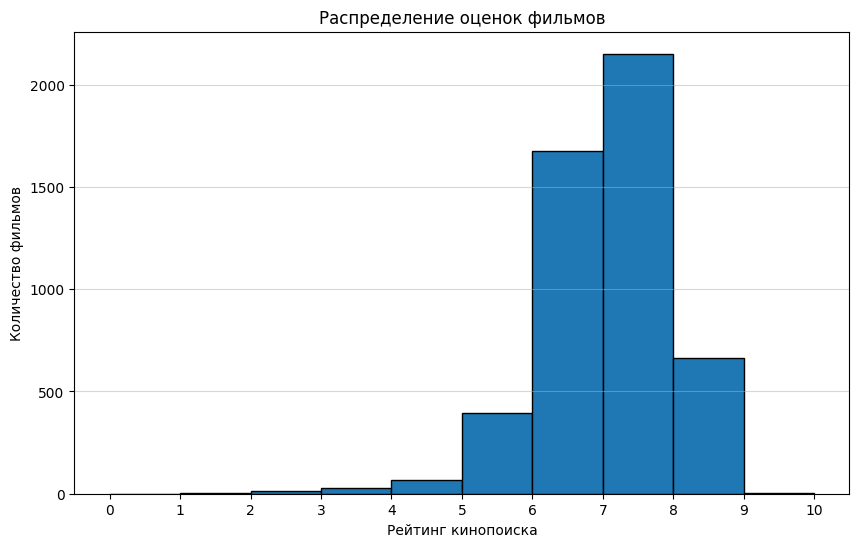

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(df['Рейтинг'], bins=range(0, 11), edgecolor='black')
plt.xlabel('Рейтинг кинопоиска')
plt.ylabel('Количество фильмов')
plt.title('Распределение оценок фильмов')
plt.xticks(range(0, 11))
plt.grid(axis='y', alpha=0.5)

plt.show()

Построим еще следующие графики, чтобы рассмотреть получше распределение оценок.

1) Плотность KDE поверх гистограммы (распределения) позволяет увидеть сглаженную форму распределения. Распределение данных похоже на нормальное, но смещено.

2) Q-Q график сравнивает распределение данных с нормальным распределением. Если точки лежат близко к прямой линии, то данные следуют нормальному распределению: на нашем графике ближе к среднему значению распределение действительно приближено к нормальному, а вот хвосты уже подкачали.

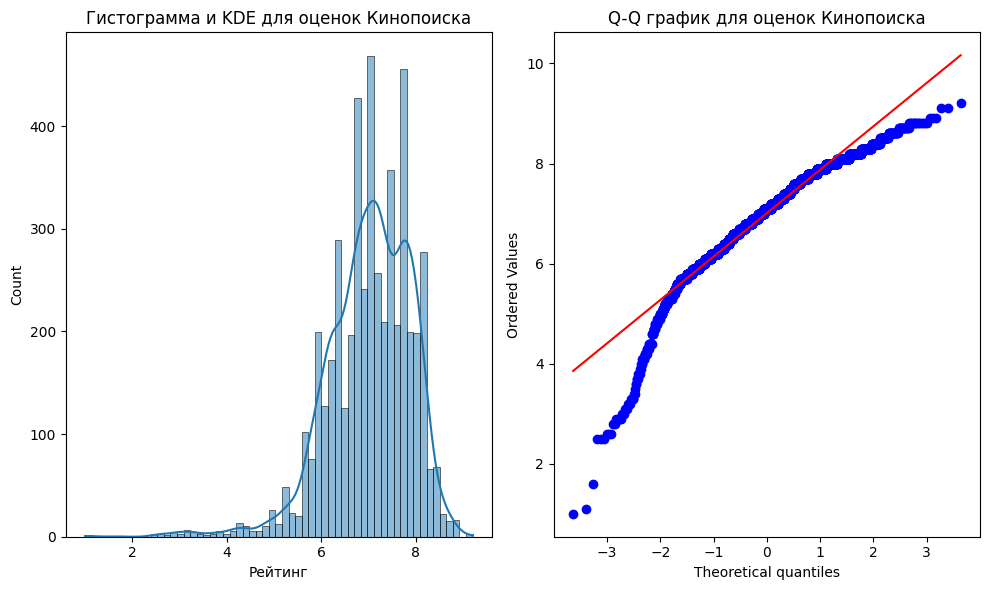

In [20]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Рейтинг'], kde=True)
plt.title('Гистограмма и KDE для оценок Кинопоиска')

plt.subplot(1, 2, 2)
stats.probplot(df['Рейтинг'], dist="norm", plot=plt)
plt.title('Q-Q график для оценок Кинопоиска')

plt.tight_layout()
plt.show()

Посмотрим конктретнее на распределение оценок

In [21]:
bins = np.arange(0, 11, 1)
data = df.copy()
data['Диапазон'] = pd.cut(data['Рейтинг'], bins=bins, right=False, labels=[f'{i}-{i+1}' for i in range(0, 10)])

distribution = data.groupby('Диапазон', observed=True).size().reset_index(name='Количество фильмов')
distribution

,Диапазон,Количество фильмов
0,1-2,3
1,2-3,13
2,3-4,29
3,4-5,67
4,5-6,397
5,6-7,1674
6,7-8,2152
7,8-9,662
8,9-10,3


Строим распределение количества оценок, так как это тоже важно. Чем популярнее фильм, тем больше у него оценок на Кинопоиске от пользователей, причем это скорее играет в худшую сторону для фильма (непопулярный фильм смотрят только те, кому нравится такое, и ставят ему высокие оценки, т.е. завышается оценка - есть байес). Видим, что фильмов с огромным количеством оценок маловато, и больше фильмов с количеством оценок порядка тысячи - нескольки тысяч.

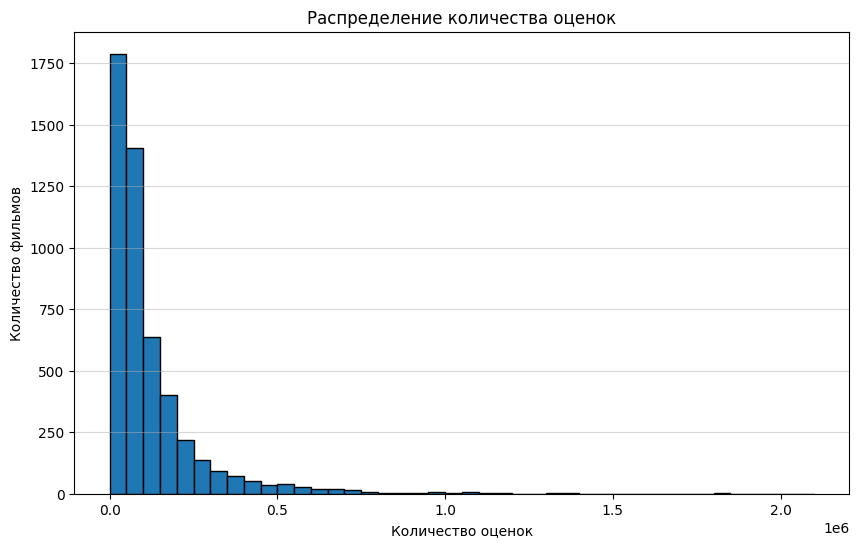

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df['Количество Оценок'], bins=np.arange(0, 2115000, 50000), edgecolor='black')
plt.xlabel('Количество оценок')
plt.ylabel('Количество фильмов')
plt.title('Распределение количества оценок')
plt.grid(axis='y', alpha=0.5)

plt.show()

Далее будем анализировать фильмы и рейтинги по **странам**. Тут уже выдвинем основные гипотезы: фильмы в США и Европе (Великобритании в основном) должны иметь выше рейтинг и быть популярнее (больше количество оценок), а, например, в России оценки должны быть ниже (довольно популярное мнение, что у нас снимаются плохие фильмы), + советские фильмы должны оцениваться выше русских. На остальные страны тяжелее выдвигать гипотезы, так как они менее представлены на Кионопоиске. Все-таки это русский сайт, а поэтому, если и в списке будет индийский или корейский фильм, то он будет самый лучший - будет завышена оценка по стране. С русскими фильмами такое с меньшей вероятностью должно происходить. 

Для начала создаем табличку со всей инфой по стране.

In [23]:
def most_popular_genre(genres):
    return genres.value_counts().idxmax()

def least_popular_genre(genres):
    return genres.value_counts().idxmin()

info_country = df.groupby('Страна').agg(
    Количество_фильмов=('Рейтинг', 'size'),
    Средний_рейтинг=('Рейтинг', 'mean'),
    Мин_рейтинг=('Рейтинг', 'min'),
    Макс_рейтинг=('Рейтинг', 'max'),
    Среднее_колво_оценок=('Количество Оценок', 'mean'),
    Самый_популярный_жанр=('Жанры', most_popular_genre),
    Наименее_популярный_жанр=('Жанры', least_popular_genre),
    Среднее_число_оскаров_у_режиссера=('Оскар у режиссера', 'mean'),
    Среднее_число_оскаров_у_актеров=('Оскар у актеров', 'mean')
).reset_index()
info_country = info_country.round(2)
info_country

,Страна,Количество_фильмов,Средний_рейтинг,Мин_рейтинг,Макс_рейтинг,Среднее_колво_оценок,Самый_популярный_жанр,Наименее_популярный_жанр,Среднее_число_оскаров_у_режиссера,Среднее_число_оскаров_у_актеров
0,Австралия,46,6.92,5.3,8.1,101995.37,драма,мюзикл,0.13,0.96
1,Австрия,2,6.05,5.8,6.3,36946.50,фантастика,фантастика,0.00,0.00
2,Аргентина,4,7.15,6.1,7.7,94260.00,триллер,боевик,0.00,0.00
3,Армения,1,7.20,7.2,7.2,28145.00,мультфильм,мультфильм,0.00,0.00
4,Беларусь,6,7.08,6.3,8.0,128321.17,драма,комедия,0.00,0.00
5,Бельгия,8,7.29,6.8,7.9,120074.88,мультфильм,фантастика,0.00,0.12
6,Бразилия,2,7.30,6.6,8.0,114184.00,драма,драма,0.50,0.00
7,Великобритания,411,7.08,4.2,8.6,124973.33,драма,спорт,0.36,1.08
8,Венгрия,3,7.37,5.9,8.1,46476.33,драма,ужасы,0.00,0.00
9,Германия,95,7.16,4.8,8.6,92258.16,драма,военный,0.06,0.58


Пришлось переводить страны на английский, так как для геопандаса нужны английские имена. Сначала строим карту распределения фильмов по странам.

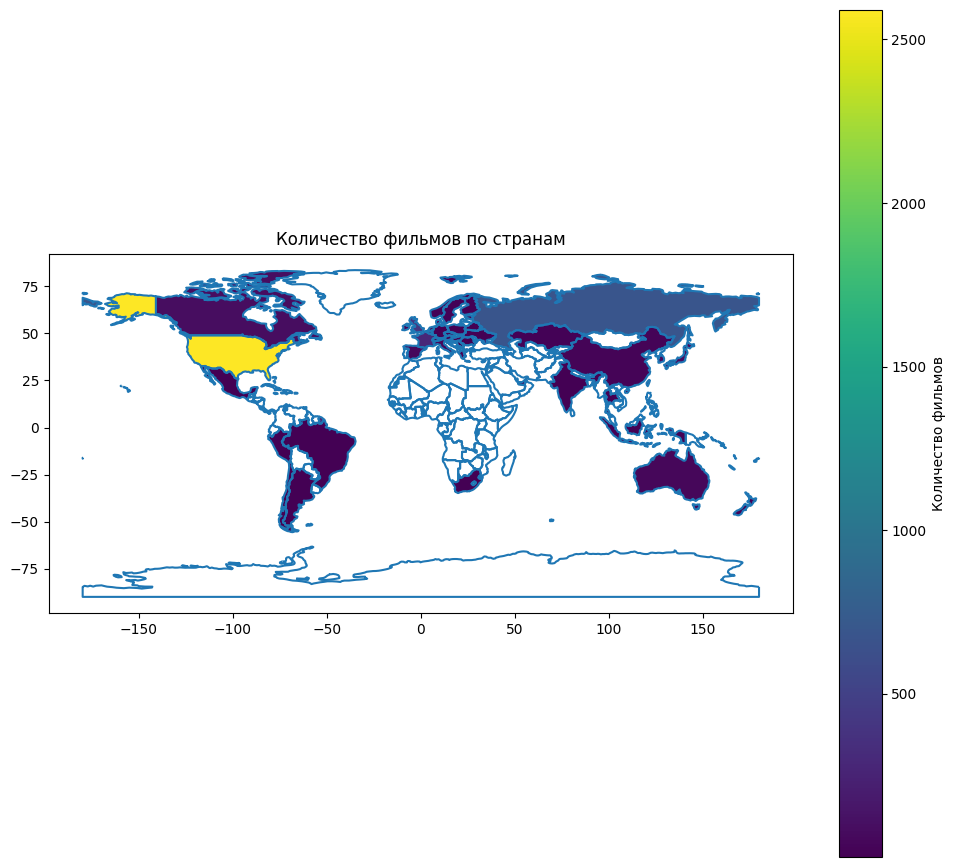

In [24]:
country_mapping = {
    'Австралия': 'Australia',
    'Австрия': 'Austria',
    'Аргентина': 'Argentina',
    'Армения': 'Armenia',
    'Беларусь': 'Belarus',
    'Бельгия': 'Belgium',
    'Бразилия': 'Brazil',
    'Великобритания': 'United Kingdom',
    'Венгрия': 'Hungary',
    'Германия': 'Germany',
    'Германия (ФРГ)': 'Germany',
    'Гонконг': 'Hong Kong',
    'Греция': 'Greece',
    'Дания': 'Denmark',
    'Индия': 'India',
    'Индонезия': 'Indonesia',
    'Ирландия': 'Ireland',
    'Испания': 'Spain',
    'Италия': 'Italy',
    'Казахстан': 'Kazakhstan',
    'Канада': 'Canada',
    'Китай': 'China',
    'Корея Южная': 'South Korea',
    'Ливан': 'Lebanon',
    'Мексика': 'Mexico',
    'Нидерланды': 'Netherlands',
    'Новая Зеландия': 'New Zealand',
    'Норвегия': 'Norway',
    'ОАЭ': 'United Arab Emirates',
    'Перу': 'Peru',
    'Польша': 'Poland',
    'Россия': 'Russian Federation',
    'Румыния': 'Romania',
    'СССР': 'Soviet Union', 
    'США': 'United States',
    'Сербия': 'Serbia',
    'Таиланд': 'Thailand',
    'Тайвань': 'Taiwan',
    'Украина': 'Ukraine',
    'Финляндия': 'Finland',
    'Франция': 'France',
    'Чехия': 'Czech Republic',
    'Чехословакия': 'Czechoslovakia',
    'Чили': 'Chile',
    'Швейцария': 'Switzerland',
    'Швеция': 'Sweden',
    'Эстония': 'Estonia',
    'ЮАР': 'South Africa',
    'Япония': 'Japan'
}

info_country['country_name_en'] = info_country['Страна'].map(country_mapping)

def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

info_country['country_code'] = info_country['country_name_en'].apply(get_country_code)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(info_country, how="left", left_on="iso_a3", right_on="country_code")

fig, ax = plt.subplots(figsize=(12, 11))
world.boundary.plot(ax=ax)
world.plot(column='Количество_фильмов', ax=ax, legend=True,
           legend_kwds={'label': "Количество фильмов"})
ax.set_title('Количество фильмов по странам')

plt.show()

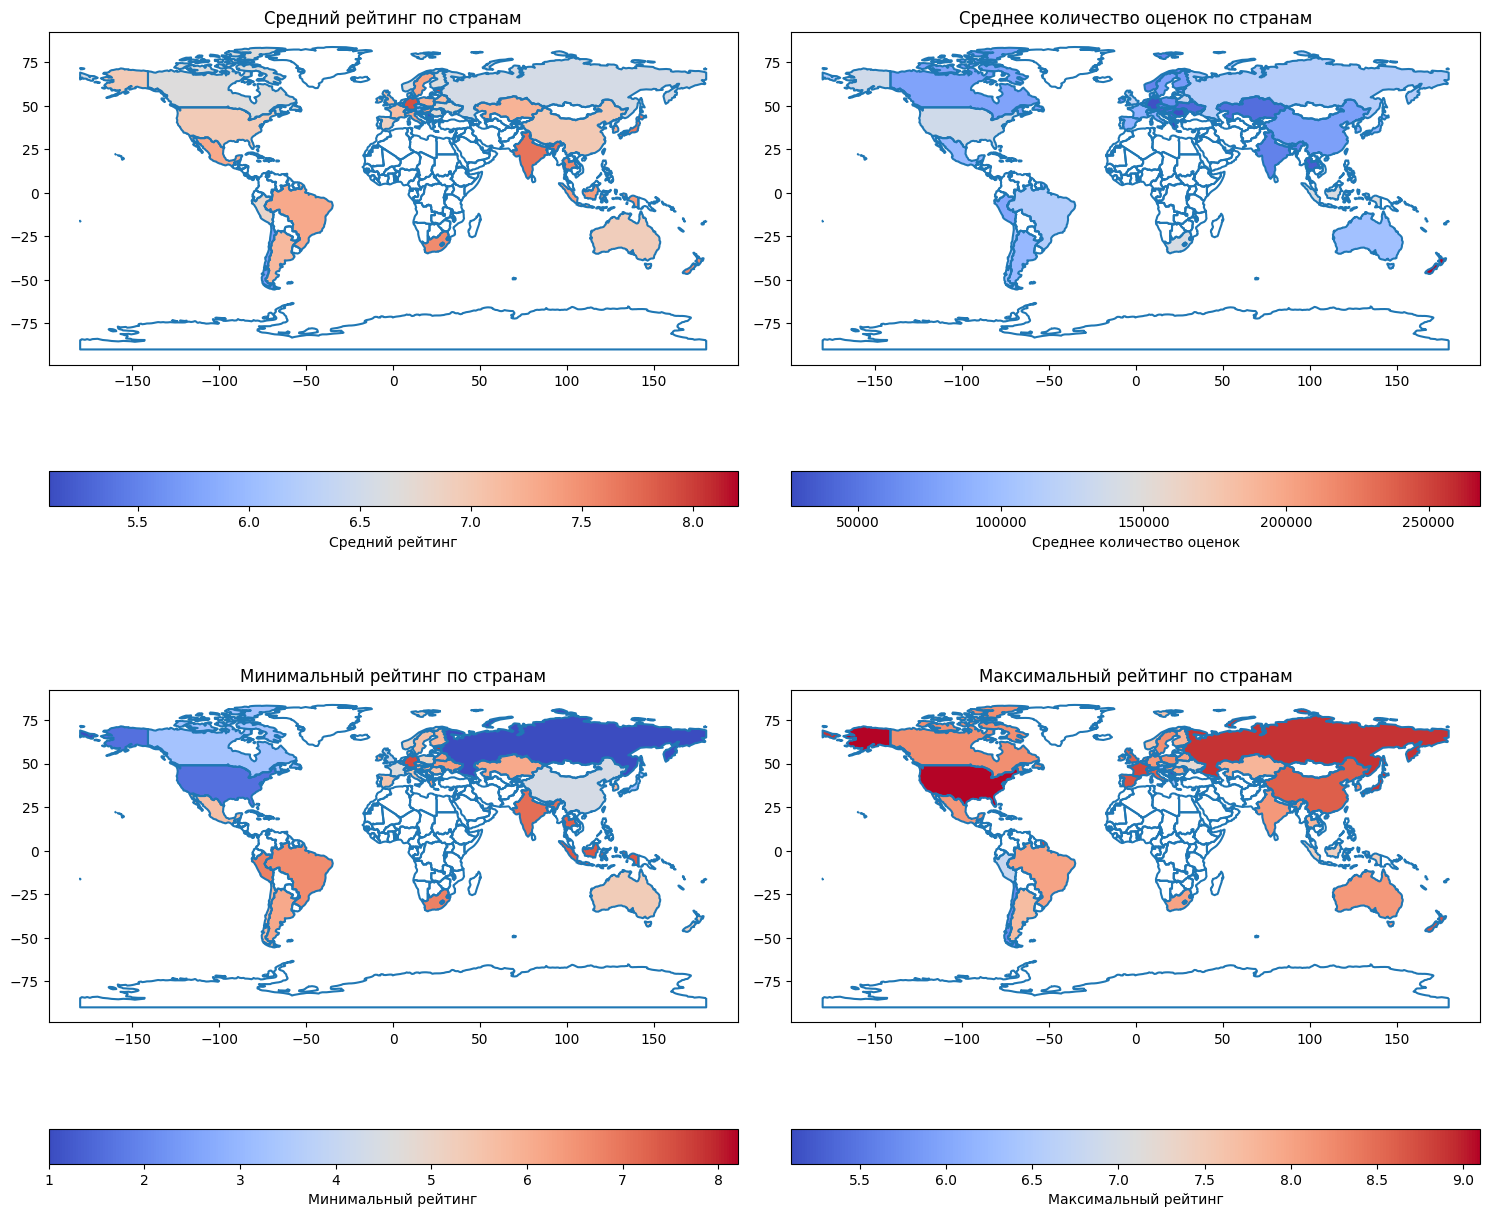

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 14))

world.boundary.plot(ax=axs[0, 0])
world.plot(column='Средний_рейтинг', ax=axs[0, 0], cmap='coolwarm', legend=True,
           legend_kwds={'label': "Средний рейтинг", 'orientation': "horizontal"})
axs[0, 0].set_title('Средний рейтинг по странам')

world.boundary.plot(ax=axs[0, 1])
world.plot(column='Среднее_колво_оценок', ax=axs[0, 1], cmap='coolwarm', legend=True,
           legend_kwds={'label': "Среднее количество оценок", 'orientation': "horizontal"})
axs[0, 1].set_title('Среднее количество оценок по странам')

world.boundary.plot(ax=axs[1, 0])
world.plot(column='Мин_рейтинг', ax=axs[1, 0], cmap='coolwarm', legend=True,
           legend_kwds={'label': "Минимальный рейтинг", 'orientation': "horizontal"})
axs[1, 0].set_title('Минимальный рейтинг по странам')

world.boundary.plot(ax=axs[1, 1])
world.plot(column='Макс_рейтинг', ax=axs[1, 1], cmap='coolwarm', legend=True,
           legend_kwds={'label': "Максимальный рейтинг", 'orientation': "horizontal"})
axs[1, 1].set_title('Максимальный рейтинг по странам')

plt.tight_layout()
plt.show()

Интерактивный график, на котором высвечивается сразу вся инфа по нужной стране. Удобно, можно приближать участки карты с большим количеством стран. 

In [26]:
import plotly.express as px

fig = px.choropleth(world,  
                    locations="iso_a3", 
                    color="Количество_фильмов", 
                    hover_name="Страна",
                    hover_data=["Количество_фильмов", "Средний_рейтинг", "Мин_рейтинг", "Макс_рейтинг", "Среднее_колво_оценок", "Самый_популярный_жанр", "Наименее_популярный_жанр",
       "Среднее_число_оскаров_у_режиссера", "Среднее_число_оскаров_у_актеров"],  
                    color_continuous_scale=px.colors.sequential.Plasma,  
                    labels={'Количество_фильмов': 'Количество фильмов'},  
                    title='Информация о стране',  
                    )

fig.update_geos(showcountries=True, countrycolor="Black")  
fig.update_layout(geo=dict(showframe=False, showcoastlines=False),
                  width=1000,  
                  height=800)
fig.show()

Результаты гипотез: у США действительно выше рейтинг, чем у России (причем любой, и средний, и минимальный, и максимальный), но ниже, чем у многих стран Европы (это связано с большим разбросом фильмов в США). Российские фильмы похуже, чем в США и в среднем по Европе (из-за смещения не берем в расчет страны с маленьким количеством фильмов). СССР нет на графике, но по таблице видно, что показатели там получше, чем у современных российских фильмов. 

Я не планировала это, но стало интересно посмотреть, что будет. Собираю данные по ВВП на душу населения из Википедии и сопоставляю с данными по фильмам.

In [27]:
service = Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)

url_ = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita'
driver.get(url_)

time.sleep(20)

info = driver.find_elements(By.XPATH, '//*[@id="mw-content-text"]/div[1]/table[1]')
info = [element.text for element in info]
info

['GDP per capita (current international dollar) by country or  territory, non-sovereign state or non-IMF member \nCountry/Territory UN Region IMF[5][6] World Bank[7] CIA[8][9][10]\nProjection Year Estimate Year Estimate Year\n Luxembourg\u202f* Europe 143,743 2024 142,214 2022 115,700 2021\n Liechtenstein\u202f* Europe — — 139,100 2009\n Ireland\u202f* Europe 133,822 2024 126,905 2022 102,500 2021\n Singapore\u202f* Asia 133,737 2024 127,565 2022 106,000 2021\n Macau\u202f* Asia 125,510 2024 61,231 2022 64,800 2021\n Monaco\u202f* Europe — — 115,700 2015\n Qatar\u202f* Asia 112,283 2024 114,648 2022 92,200 2021\n United Arab Emirates\u202f* Asia 96,846 2024 87,729 2022 69,700 2021\n Bermuda\u202f* Americas — 95,869 2022 80,300 2021\n Switzerland\u202f* Europe 91,932 2024 90,746 2022 71,000 2021\n San Marino\u202f* Europe 86,989 2024 59,451 2020 56,400 2020\n United States\u202f* Americas 85,373 2024 76,330 2022 63,700 2021\n Isle of Man\u202f* Europe — — 84,600 2014\n Cayman Islands\u2

In [28]:
parsed_data = {}

info_gdp = info[0].split("\n")[1:]
for line in info_gdp:
    country_match = re.match(r"^(.*?)\u202f\*", line)
    if country_match:
        country = country_match.group(1)
    else:
        continue  

    gdp_match = re.search(r"(\d{1,3}(?:,\d{3})*(?:\.\d+)?)", line)
    
    if gdp_match:
        gdp_per_capita = gdp_match.group(0).replace(',', '')
    else:
        gdp_per_capita = None
    
    parsed_data[country.strip()] = gdp_per_capita

parsed_data['Russian Federation'] = parsed_data.pop('Russia') ### тут тоже пришлось ручками поменять, не сходилось

In [29]:
gdp_df = pd.DataFrame(list(parsed_data.items()), columns=['country_name_en', 'GDP_per_capita'])
gdp_df['GDP_per_capita'] = pd.to_numeric(gdp_df['GDP_per_capita'])

info_country = pd.merge(info_country, gdp_df, on='country_name_en', how='left')
info_country

,Страна,Количество_фильмов,Средний_рейтинг,Мин_рейтинг,Макс_рейтинг,Среднее_колво_оценок,Самый_популярный_жанр,Наименее_популярный_жанр,Среднее_число_оскаров_у_режиссера,Среднее_число_оскаров_у_актеров,country_name_en,country_code,GDP_per_capita
0,Австралия,46,6.92,5.3,8.1,101995.37,драма,мюзикл,0.13,0.96,Australia,AUS,66627.0
1,Австрия,2,6.05,5.8,6.3,36946.50,фантастика,фантастика,0.00,0.00,Austria,AUT,69460.0
2,Аргентина,4,7.15,6.1,7.7,94260.00,триллер,боевик,0.00,0.00,Argentina,ARG,26390.0
3,Армения,1,7.20,7.2,7.2,28145.00,мультфильм,мультфильм,0.00,0.00,Armenia,ARM,21746.0
4,Беларусь,6,7.08,6.3,8.0,128321.17,драма,комедия,0.00,0.00,Belarus,BLR,25685.0
5,Бельгия,8,7.29,6.8,7.9,120074.88,мультфильм,фантастика,0.00,0.12,Belgium,BEL,68079.0
6,Бразилия,2,7.30,6.6,8.0,114184.00,драма,драма,0.50,0.00,Brazil,BRA,20809.0
7,Великобритания,411,7.08,4.2,8.6,124973.33,драма,спорт,0.36,1.08,United Kingdom,GBR,58880.0
8,Венгрия,3,7.37,5.9,8.1,46476.33,драма,ужасы,0.00,0.00,Hungary,HUN,45692.0
9,Германия,95,7.16,4.8,8.6,92258.16,драма,военный,0.06,0.58,Germany,DEU,67245.0


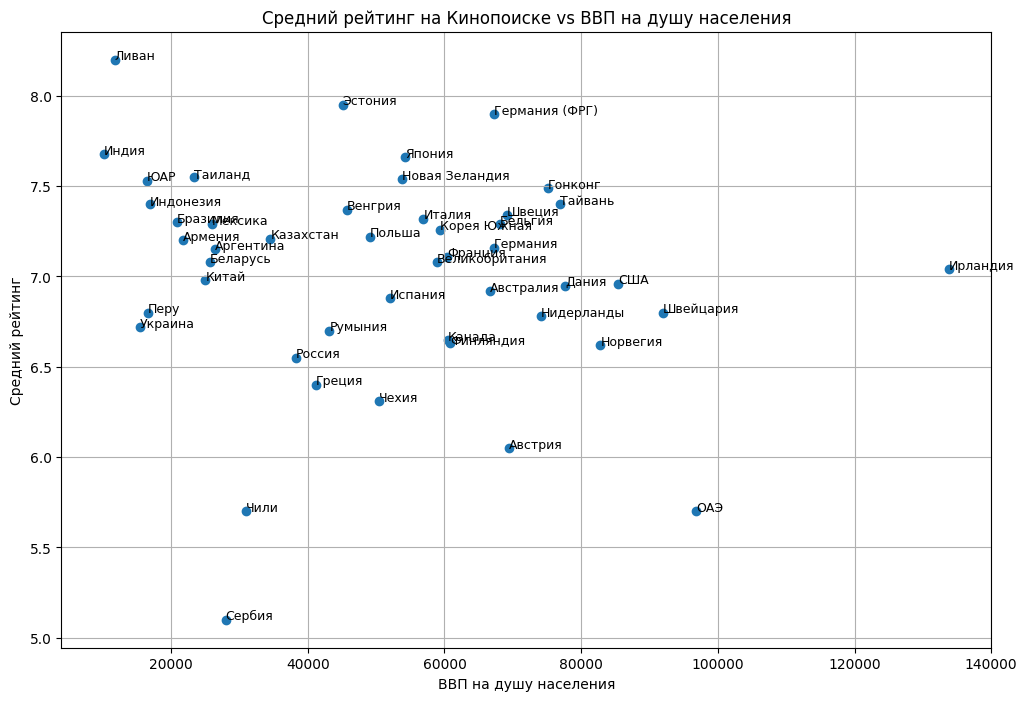

In [30]:
plt.figure(figsize=(12, 8))
finite_values_mask = np.isfinite(info_country['GDP_per_capita']) & np.isfinite(info_country['Средний_рейтинг'])

plt.scatter(info_country['GDP_per_capita'][finite_values_mask], info_country['Средний_рейтинг'][finite_values_mask])

for i in range(len(info_country)):
    if finite_values_mask[i]:
        plt.text(info_country['GDP_per_capita'][i], info_country['Средний_рейтинг'][i], info_country['Страна'][i], fontsize=9)

plt.title('Средний рейтинг на Кинопоиске vs ВВП на душу населения')
plt.xlabel('ВВП на душу населения')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()

Попыталась сделать график как будто он из какой-то экономической статьи. На самом деле, если убирать страны с малым количеством фильмов (по сути, выбросы - страны с парой лучших фильмов попали в наш датасет), то получается скорее отрицательная корреляция, которая вполне оправдана: чем больше ВВП на душу населения, тем богаче страна, тем больше фильмов она будет снимать, тогда больше фильмов становятся популярными, их много смотрят, а такие фильмы в среднем получают оценки ниже из-за разного количества мнений/массовости и т.д.

Смотрим теперь на год выпуска и как он связан с оценками. Тут скорее непонятно, есть гипотеза, что старые фильмы могут получать оценки выше (раньше было лучше или что-то в этом духе). Но для начала посмотрим, как разные годы выпуска представлены в нашем датасете.

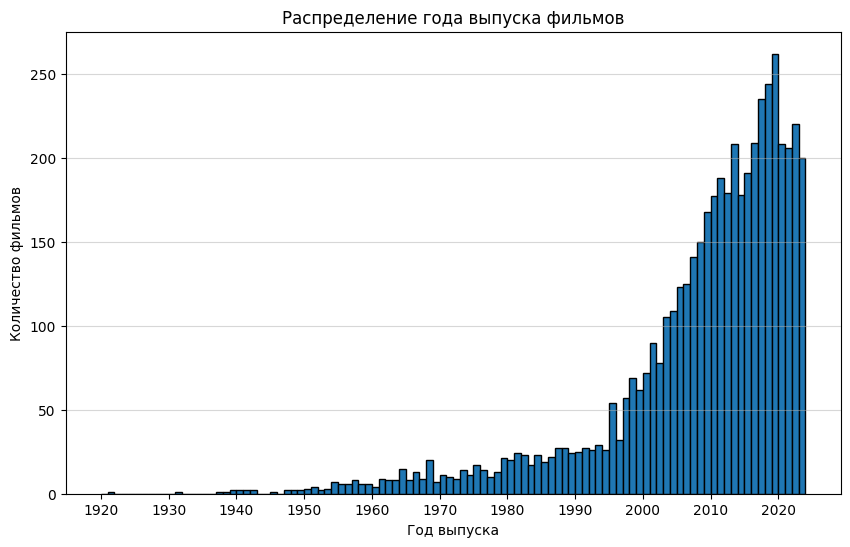

In [31]:
df['Год выпуска'] = df['Год выпуска'].astype(int)

plt.figure(figsize=(10, 6))
plt.hist(df['Год выпуска'], bins=range(1920, 2025), edgecolor='black')
plt.xlabel('Год выпуска')
plt.ylabel('Количество фильмов')
plt.title('Распределение года выпуска фильмов')
plt.xticks(range(1920, 2025, 10))
plt.grid(axis='y', alpha=0.5)

plt.show()

Воспользуемся SQL чтобы сосчитать количество фильмов в каждом пятилетии.

In [32]:
df_sql = df.copy().rename(columns={'Год выпуска': 'release_year'})
df_sql = df_sql.rename(columns={'Количество Оценок': 'num_ratings'})
connect_ = duckdb.connect(database=':memory:')

connect_.execute("CREATE TABLE movies AS SELECT * FROM df_sql")
query = """
SELECT 
    (release_year - (release_year % 5)) AS Пятилетие, 
    COUNT(*) AS Количество
FROM movies
GROUP BY Пятилетие
ORDER BY Пятилетие
"""

year_distribution = connect_.execute(query).fetchdf()
year_distribution

,Пятилетие,Количество
0,1920,1
1,1930,1
2,1935,4
3,1940,6
4,1945,7
5,1950,19
6,1955,32
7,1960,44
8,1965,57
9,1970,55


Теперь посмотрим на зависимости от рейтинга.

In [33]:
df_sql = df_sql.rename(columns={'Рейтинг': 'rating'})
connect_.execute("CREATE TABLE rating_year AS SELECT * FROM df_sql")
query = """
SELECT 
    release_year, 
    ROUND(AVG(rating), 2) AS average_rating,
    MIN(rating) AS min_rating,
    MAX(rating) AS max_rating
FROM rating_year
GROUP BY release_year
ORDER BY release_year
"""

avg_rating_by_year = connect_.execute(query).fetchdf()
avg_rating_by_year

,release_year,average_rating,min_rating,max_rating
0,1921,8.30,8.3,8.3
1,1931,8.50,8.5,8.5
2,1937,7.90,7.9,7.9
3,1938,8.00,8.0,8.0
4,1939,8.25,8.1,8.4
...,...,...,...,...
82,2020,6.73,4.4,8.5
83,2021,6.71,3.4,8.6
84,2022,6.86,5.0,8.7
85,2023,6.85,2.6,8.6


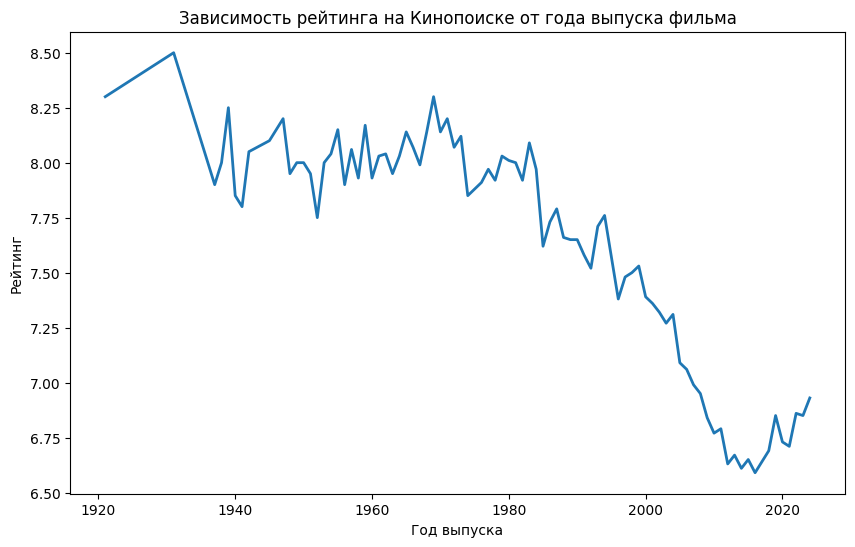

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(avg_rating_by_year['release_year'], avg_rating_by_year['average_rating'], linewidth=2)

plt.xlabel('Год выпуска')
plt.ylabel('Рейтинг')
plt.title('Зависимость рейтинга на Кинопоиске от года выпуска фильма')

plt.show()

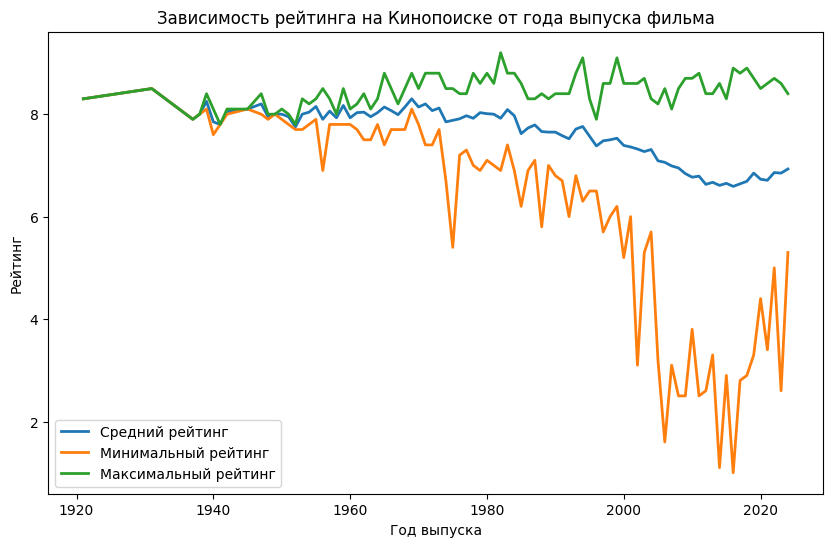

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(avg_rating_by_year['release_year'], avg_rating_by_year['average_rating'], label='Средний рейтинг', linewidth=2)
plt.plot(avg_rating_by_year['release_year'], avg_rating_by_year['min_rating'], label='Минимальный рейтинг', linewidth=2)
plt.plot(avg_rating_by_year['release_year'], avg_rating_by_year['max_rating'], label='Максимальный рейтинг', linewidth=2)

plt.xlabel('Год выпуска')
plt.ylabel('Рейтинг')
plt.title('Зависимость рейтинга на Кинопоиске от года выпуска фильма')
plt.legend()

plt.show()

Гипотеза в целом потвердилась, видна просадка по рейтингам в 21 веке. Но это может быть связано с тем, что в датасете представлено больше хороших фильмов 20 века и много разных фильмов 21 века, поэтому у старых фильмов получаются оценки выше. Ниже построена зависимость только по 21 веку, средний рейтинг там довольно постоянный (то есть от года выпуска качество фильма скорее не сильно зависит).

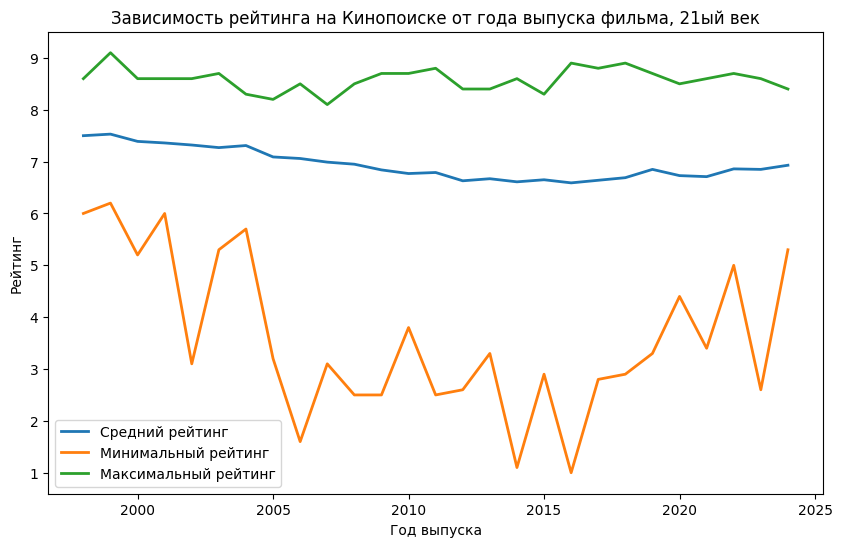

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(avg_rating_by_year['release_year'][60:], avg_rating_by_year['average_rating'][60:], label='Средний рейтинг', linewidth=2)
plt.plot(avg_rating_by_year['release_year'][60:], avg_rating_by_year['min_rating'][60:], label='Минимальный рейтинг', linewidth=2)
plt.plot(avg_rating_by_year['release_year'][60:], avg_rating_by_year['max_rating'][60:], label='Максимальный рейтинг', linewidth=2)

plt.xlabel('Год выпуска')
plt.ylabel('Рейтинг')
plt.title('Зависимость рейтинга на Кинопоиске от года выпуска фильма, 21ый век')
plt.legend()

plt.show()

Теперь группируем все по жанрам. Гипотезы: самый популярный жанр - драма (сейчас любой фильм - драма), поэтому у него оценки будут на среднем уровне. Высокие оценки будут у мультиков (предполагаю так, потому что, наверное, никто не ставит плохие оценки мультикам), а низкие - у популяных жанров, может быть комедии, ужасы. Жанры редкие, "для ценителей", скорее будут оцениваться выше, так как только ценители и будут их смотреть. Давайте проверять гипотезы.

In [37]:
query_most_popular_genre = """
SELECT
    Жанры,
    COUNT(*) AS количество_фильмов
FROM
    movies
GROUP BY
    Жанры
ORDER BY
    количество_фильмов DESC
LIMIT 1;
"""

query_least_popular_genre = """
SELECT
    Жанры,
    COUNT(*) AS количество_фильмов
FROM
    movies
GROUP BY
    Жанры
ORDER BY
    количество_фильмов ASC
LIMIT 1;
"""

query_avg_rating_by_genre = """
SELECT
    Жанры,
    ROUND(AVG(Рейтинг), 2) AS средний_рейтинг,
    COUNT(*) AS частота_встречи,
    ROUND(AVG(num_ratings), 2) AS кол_во_оценок,
FROM
    movies
GROUP BY
    Жанры;
"""

most_popular_genre = connect_.execute(query_most_popular_genre).fetchall()
least_popular_genre = connect_.execute(query_least_popular_genre).fetchall()
avg_rating_by_genre = connect_.execute(query_avg_rating_by_genre).fetchall()

print("Самый популярный жанр:", most_popular_genre)
print("Наименее популярный жанр:", least_popular_genre)

Самый популярный жанр: [('драма', 1037)]
Наименее популярный жанр: [('фильм-нуар', 2)]


In [38]:
avg_rating_by_genre = pd.DataFrame(avg_rating_by_genre, columns=['Жанр', 'Средний рейтинг', 'Количество фильмов', 'Среднее количество оценок'])
avg_rating_by_genre

,Жанр,Средний рейтинг,Количество фильмов,Среднее количество оценок
0,биография,7.40,65,150705.11
1,история,6.66,15,142510.40
2,аниме,7.90,50,97478.56
3,детский,7.85,4,140056.75
4,фильм-нуар,8.00,2,47822.00
5,семейный,6.67,21,111045.95
6,криминал,7.61,47,271667.23
7,боевик,6.92,609,117137.32
8,детектив,6.96,53,126399.85
9,вестерн,7.64,17,168560.94


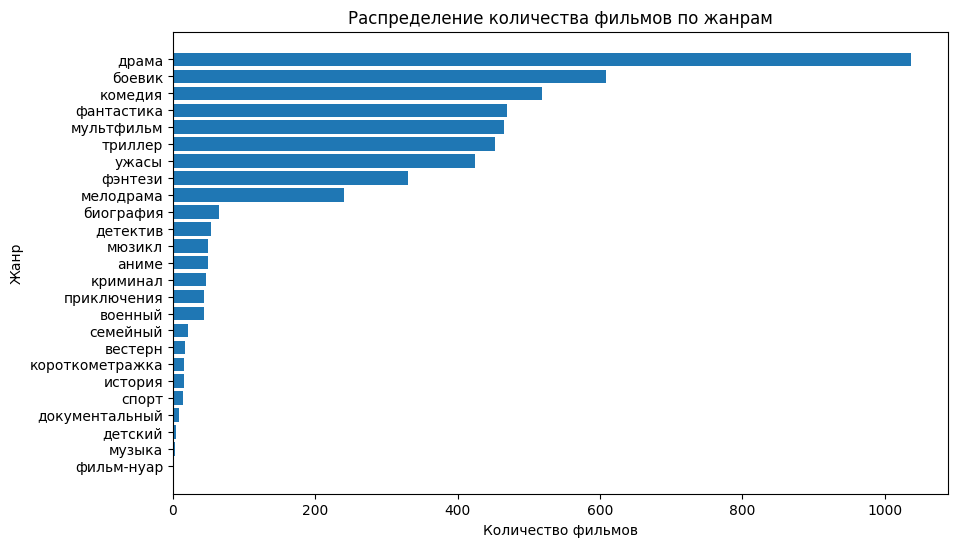

In [39]:
avg_rating_by_genre = avg_rating_by_genre.sort_values(by='Количество фильмов', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(avg_rating_by_genre['Жанр'], avg_rating_by_genre['Количество фильмов'])
plt.xlabel('Количество фильмов')
plt.ylabel('Жанр')
plt.title('Распределение количества фильмов по жанрам')
plt.show()

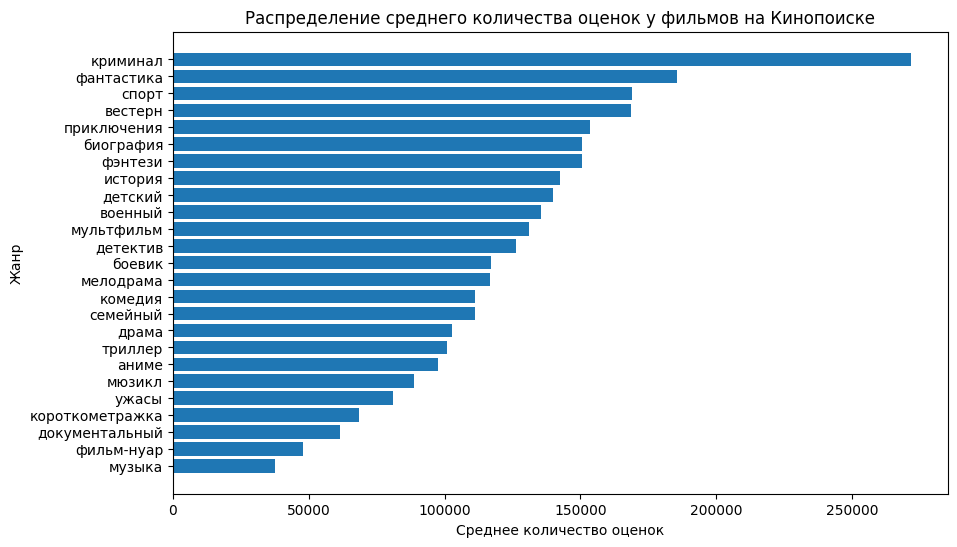

In [40]:
avg_rating_by_genre = avg_rating_by_genre.sort_values(by='Среднее количество оценок', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(avg_rating_by_genre['Жанр'], avg_rating_by_genre['Среднее количество оценок'])
plt.xlabel('Среднее количество оценок')
plt.ylabel('Жанр')
plt.title('Распределение среднего количества оценок у фильмов на Кинопоиске')
plt.show()

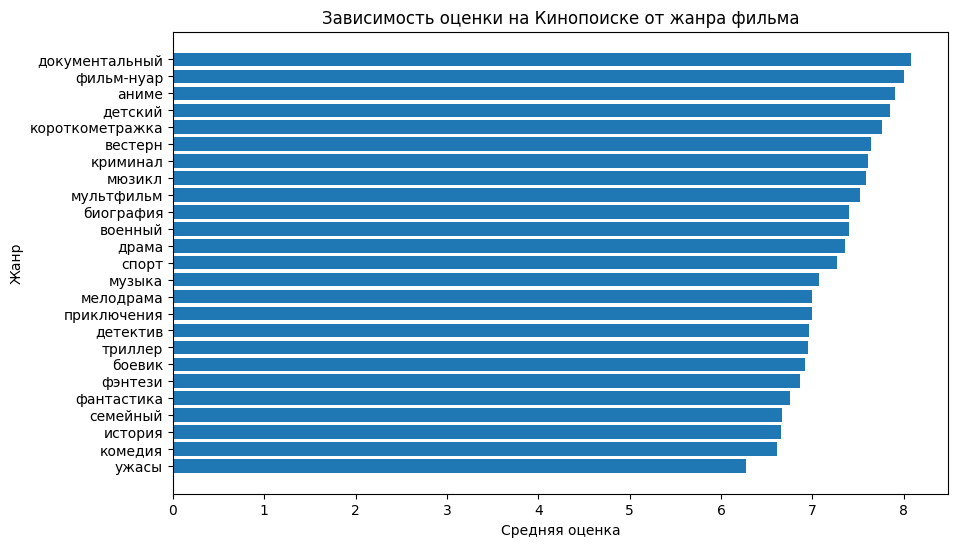

In [41]:
avg_rating_by_genre = avg_rating_by_genre.sort_values(by='Средний рейтинг', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(avg_rating_by_genre['Жанр'], avg_rating_by_genre['Средний рейтинг'])
plt.xlabel('Средняя оценка')
plt.ylabel('Жанр')
plt.title('Зависимость оценки на Кинопоиске от жанра фильма')
plt.show()

Ура, я угадала! Прям честно-честно, не подсматривала, строя гипотезу. Видно, что средняя оценка ни у одного жанра не падает ниже 6. Так что тут бОльшую роль в оценке играет скорее не качество жанра, а его популярность в массовой культуре. Стоит отметить криминал, он лидер по количеству оценок, причем средняя оценка тоже высоко, значит, тут можно сказать о том, что массовому зрителю скорее нравятся такие фильмы.

Теперь смотрим на продолжительность фильма. Тут гипотеза довольно тривиальная: долгие фильмы меньше нравятся людям, так как кажутся затянутыми. 

In [42]:
df['Диапазон продолжительности'] = (df['Продолжительность'] // 10) * 10

timing = df.groupby('Диапазон продолжительности').agg(
    Количество_фильмов=('Рейтинг', 'size'),
    Средний_рейтинг=('Рейтинг', 'mean'),
    Среднее_количество_оценок=('Количество Оценок', 'mean')
).reset_index()
timing.columns = ['Продолжительность', 'Количество фильмов', 'Средний рейтинг', 'Среднее количество оценок']
timing['Средний рейтинг'] = timing['Средний рейтинг'].round(2)
timing['Среднее количество оценок'] = timing['Среднее количество оценок'].round(2)

timing

,Продолжительность,Количество фильмов,Средний рейтинг,Среднее количество оценок
0,0.0,36,8.09,55870.86
1,10.0,56,8.15,106334.84
2,20.0,30,8.04,91750.67
3,30.0,11,8.03,63244.55
4,40.0,8,7.51,52240.12
5,50.0,11,8.01,75721.73
6,60.0,21,7.32,114952.29
7,70.0,89,7.19,98303.49
8,80.0,522,6.66,91493.06
9,90.0,1104,6.77,91408.05


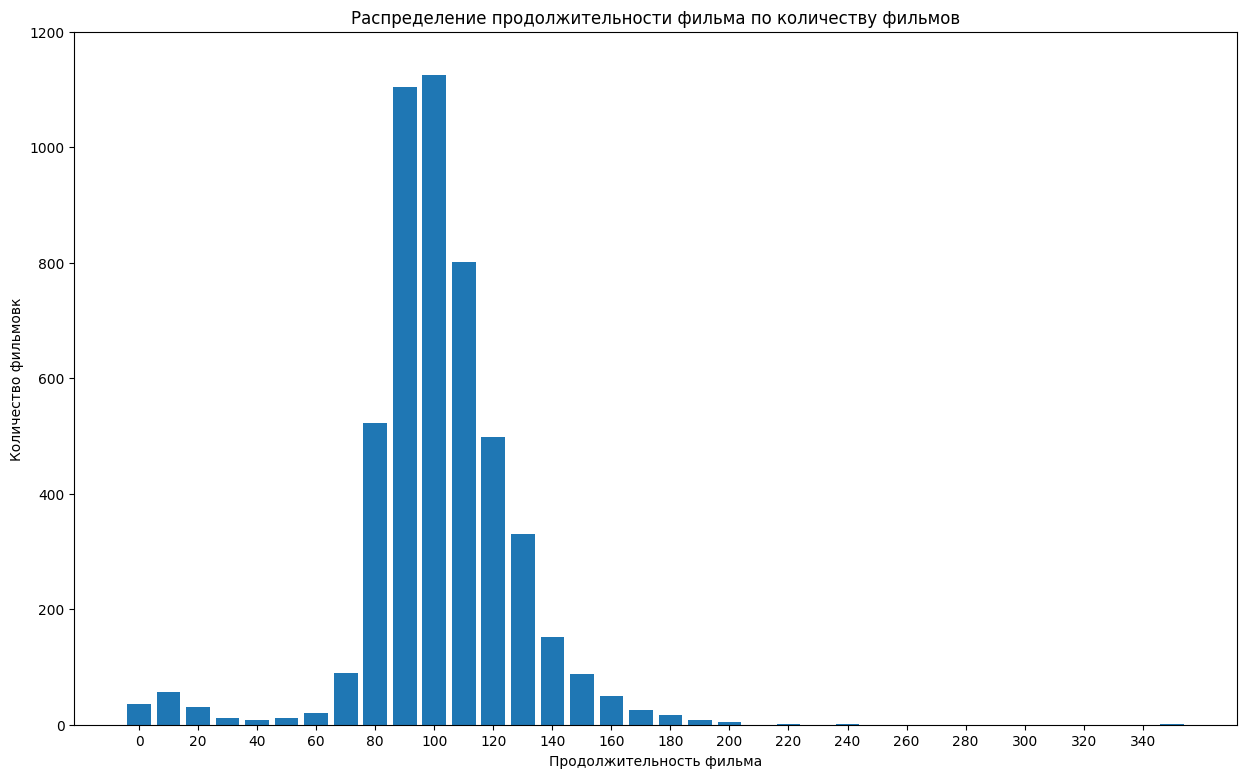

In [43]:
plt.figure(figsize=(15, 9))
bars = plt.bar(timing['Продолжительность'], timing['Количество фильмов'], width=8)

plt.xlabel('Продолжительность фильма')
plt.ylabel('Количество фильмовк')
plt.title('Распределение продолжительности фильма по количеству фильмов')
plt.xticks(range(0, 360, 20))
plt.ylim(0, 1200)
plt.show()

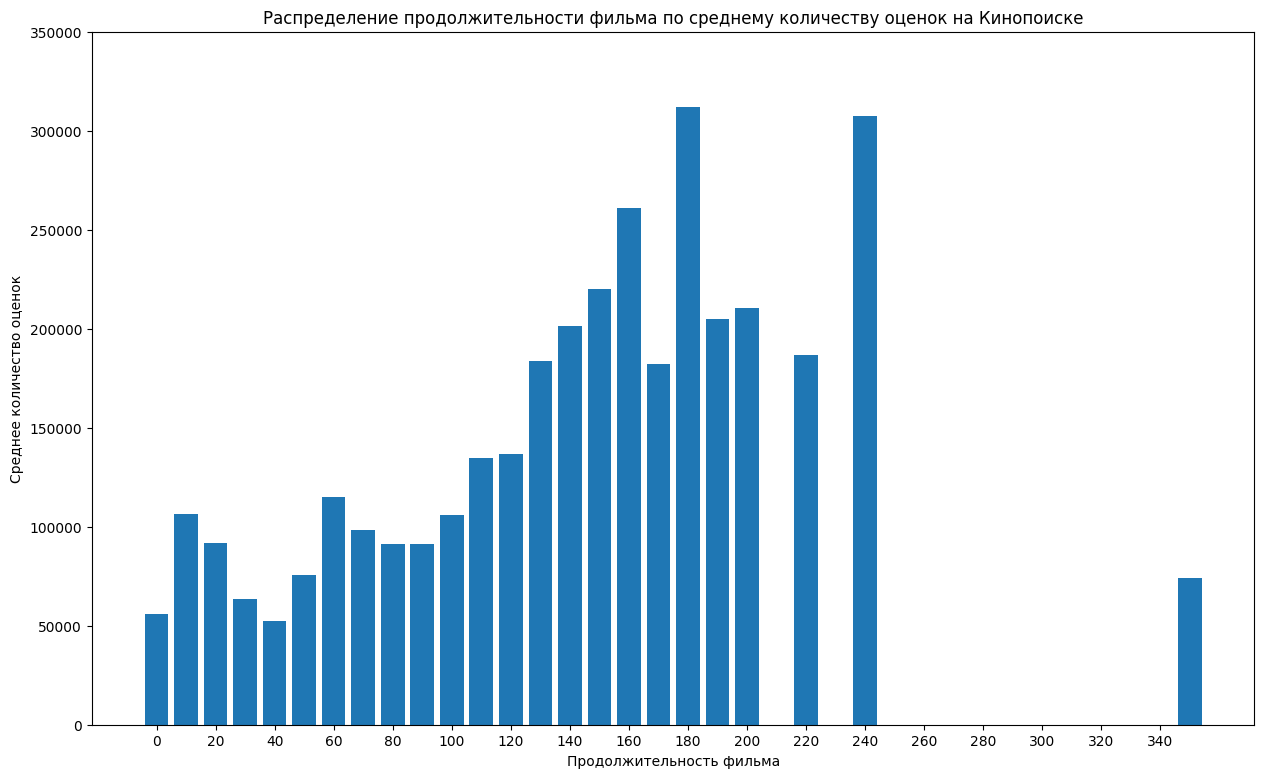

In [44]:
plt.figure(figsize=(15, 9))
bars = plt.bar(timing['Продолжительность'], timing['Среднее количество оценок'], width=8)

plt.xlabel('Продолжительность фильма')
plt.ylabel('Среднее количество оценок')
plt.title('Распределение продолжительности фильма по среднему количеству оценок на Кинопоиске')
plt.xticks(range(0, 360, 20))
plt.ylim(0, 350000)
plt.show()

Больше всего фильмов, которые идут около двух часов - стандартное время для фильма.

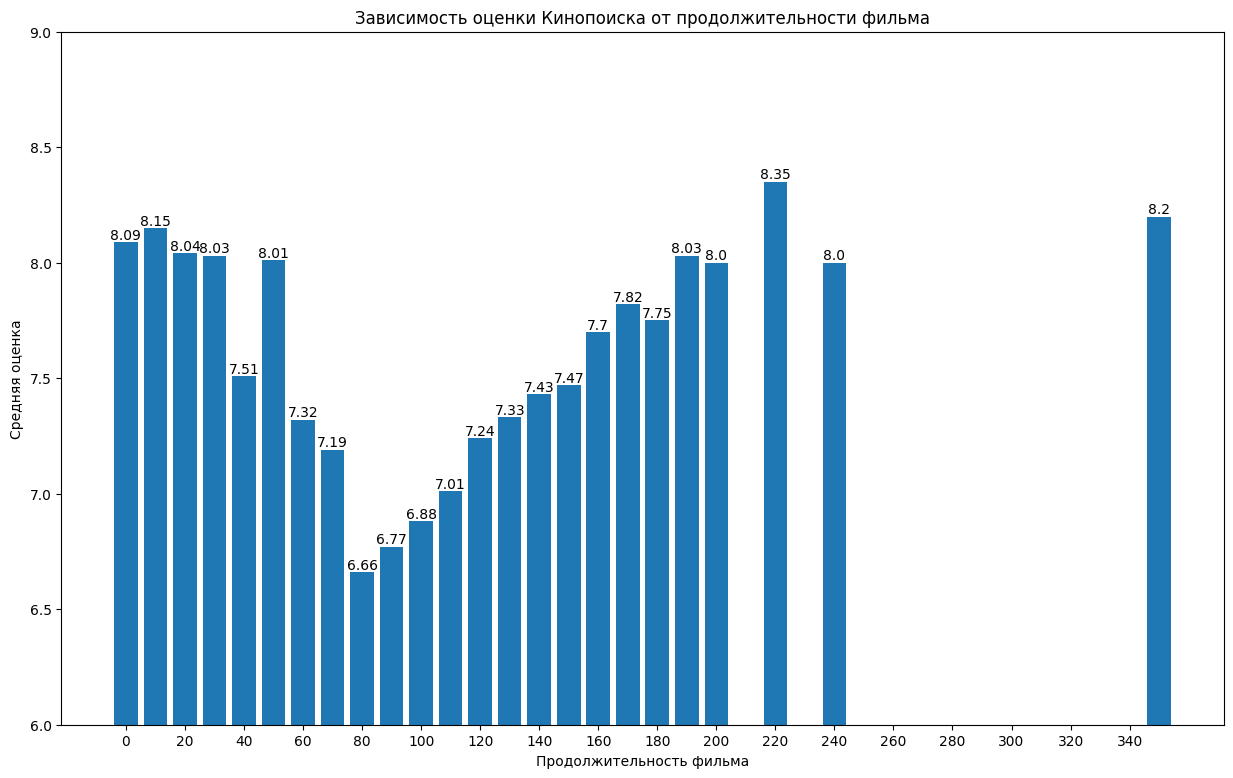

In [45]:
plt.figure(figsize=(15, 9))
bars = plt.bar(timing['Продолжительность'], timing['Средний рейтинг'], width=8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Продолжительность фильма')
plt.ylabel('Средняя оценка')
plt.title('Зависимость оценки Кинопоиска от продолжительности фильма')
plt.xticks(range(0, 360, 20))
plt.ylim(6, 9)
plt.show()

По построенному графику гипотеза не сильно подтверждается. Высокая оценка справа - точно выброс, а вот рост средней оценки с ростом продолжительности фильма до 3 часов уже тяжело объяснить. Возможно, опять же, потому что очень много фильмов с продолжительностью около 2 часов, соответственно там много плохих фильмов, которые занижают рейтинг. Высокие оценки для коротких фильмов объясняются наличием там мультиков и коротких фильмов для малых кругов аудитории.

In [46]:
df = df.drop(columns=['Диапазон продолжительности'])

Теперь смотрим на зависимости от числа номинаций на Оскар у актеров и режиссеров. Гипотеза: чем больше оскаров, тем выше должна быть оценка у фильма.

In [47]:
oscars_dir_distribution = df.groupby('Оскар у режиссера')['Рейтинг'].mean().reset_index()
oscars_dir_distribution.columns = ['Оскар у режиссера', 'Средний рейтинг']
oscars_dir_distribution['Средний рейтинг'] = oscars_dir_distribution['Средний рейтинг'].round(2)

oscars_dir_distribution

,Оскар у режиссера,Средний рейтинг
0,0,6.95
1,1,7.30
2,2,7.49
3,3,7.49
4,4,7.83
5,5,7.74
6,7,7.19
7,8,8.50
8,9,7.58
9,10,7.78


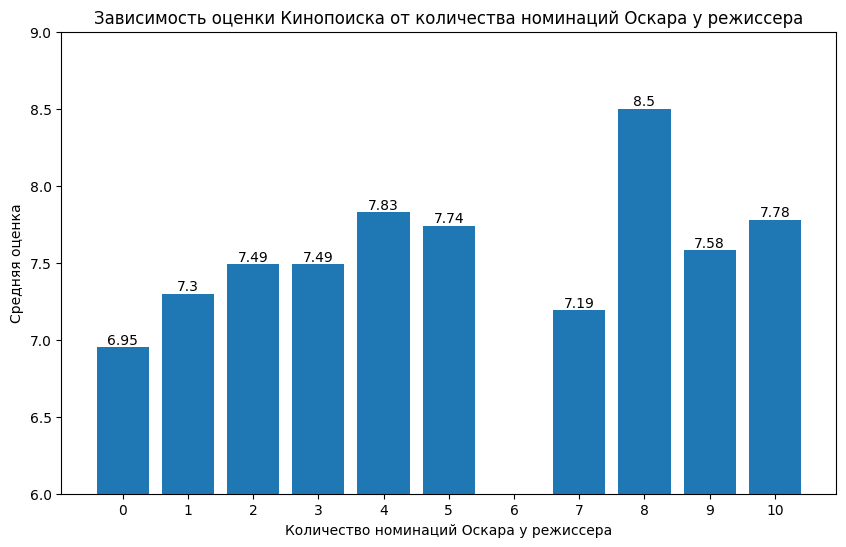

In [48]:
plt.figure(figsize=(10, 6))
bars = plt.bar(oscars_dir_distribution['Оскар у режиссера'], oscars_dir_distribution['Средний рейтинг'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Количество номинаций Оскара у режиссера')
plt.ylabel('Средняя оценка')
plt.title('Зависимость оценки Кинопоиска от количества номинаций Оскара у режиссера')
plt.xticks(range(0, 11, 1))
plt.ylim(6, 9)
plt.show()

Гипотеза в целом подтверждается, есть очень много фильмов, у режиссеров которых нет номинации на Оскар, и там средняя оценка ниже. А дальше (номинаций на Оскар больше 0) количество номинаций не сильно влияет на оценку фильма, но скорее увеличивает.

In [49]:
oscars_act_distribution = df.groupby('Оскар у актеров')['Рейтинг'].mean().reset_index()
oscars_act_distribution.columns = ['Оскар у актеров', 'Средний рейтинг']
oscars_act_distribution['Средний рейтинг'] = oscars_act_distribution['Средний рейтинг'].round(2)

oscars_act_distribution

,Оскар у актеров,Средний рейтинг
0,0,6.93
1,1,7.09
2,2,7.19
3,3,7.17
4,4,7.19
5,5,7.43
6,6,7.39
7,7,7.42
8,8,7.48
9,9,7.70


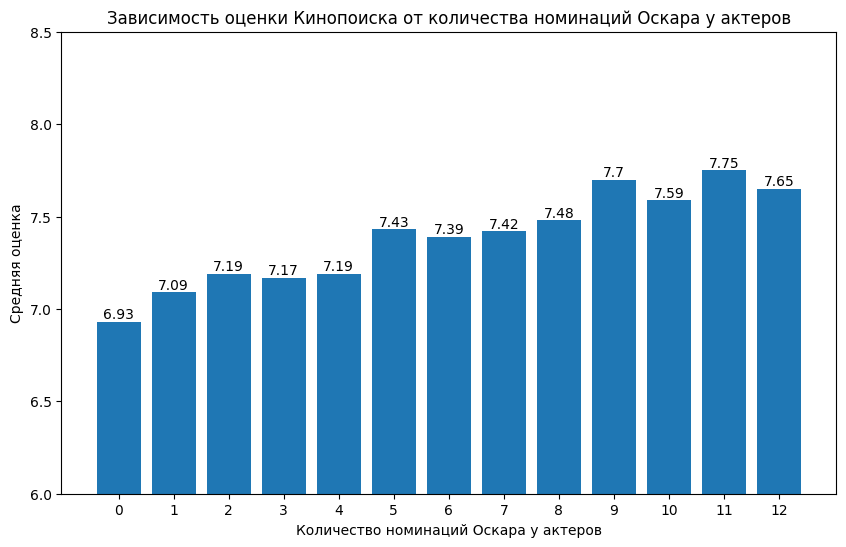

In [50]:
plt.figure(figsize=(10, 6))
bars = plt.bar(oscars_act_distribution['Оскар у актеров'], oscars_act_distribution['Средний рейтинг'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Количество номинаций Оскара у актеров')
plt.ylabel('Средняя оценка')
plt.title('Зависимость оценки Кинопоиска от количества номинаций Оскара у актеров')
plt.xticks(range(0, 13, 1))
plt.ylim(6, 8.5)
plt.show()

У актеров с номинациями такая же логика, как и у режиссеров. Причем тут даже больше прослеживается положительная зависимость оценки на Кинопоиске от количества номинаций (хоть и несильная).

Теперь сделаем прикольную штуку: посмотрим, насколько сильно актеры и режиссеры связаны между собой. Будем строить связи по первым фильмам из исходного датасета (там вверху в среднем хорошие и популярные фильмы). Поэтому внутри этих первых сотен фильмов связей должно быть много, хорошие актеры потом снимаются в других фильмах с хорошими актерами. Построим граф их связей. Чтобы не перенасыщать граф, я беру только тех актеров и режиссеров, которые встречались в части датасета более чем один раз. Вершины с актерами и режиссерами помечены разными цветами.

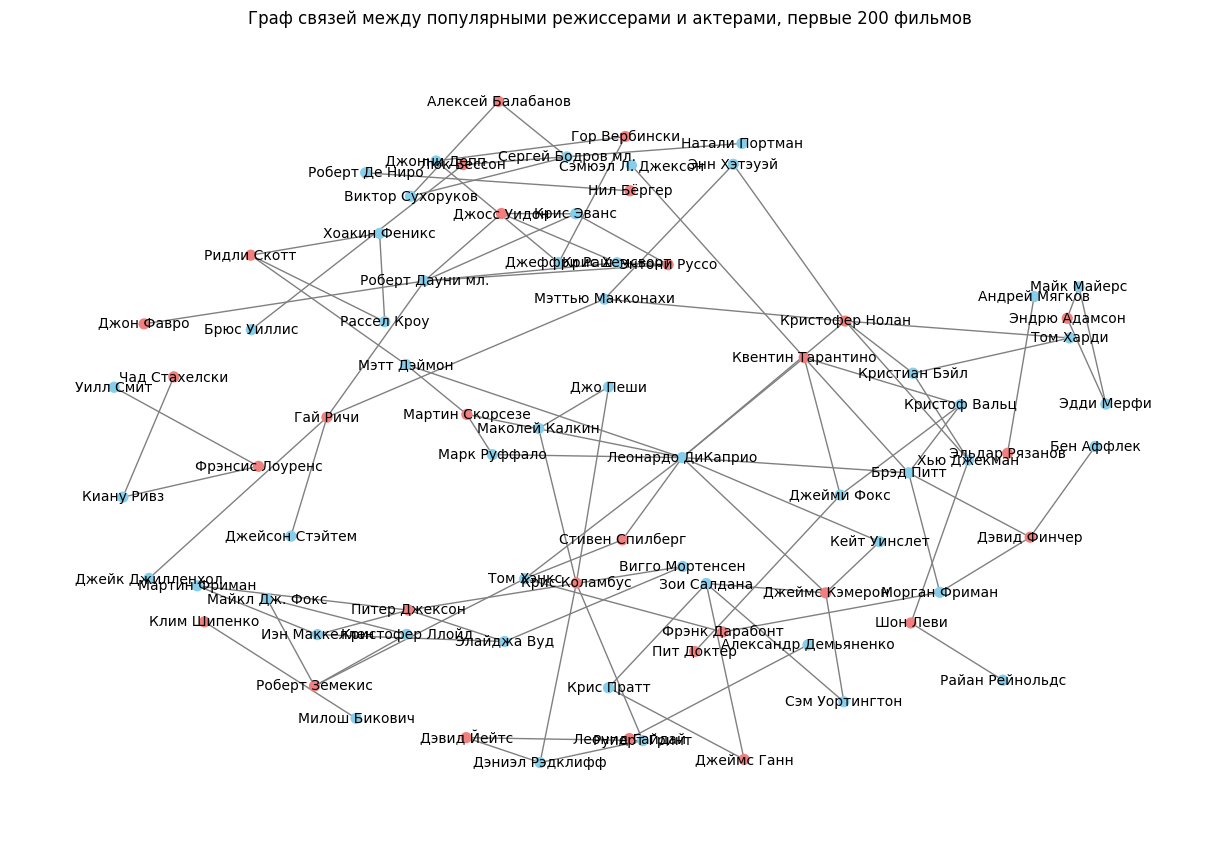

In [51]:
df_temp = df[:201]

actor_counts = Counter(df_temp['Актер 1']) + Counter(df_temp['Актер 2'])
frequent_actors = {actor for actor, count in actor_counts.items() if count > 1}
director_counts = Counter(df_temp['Режиссер'])
frequent_directors = {director for director, count in director_counts.items() if count > 1}

G = nx.Graph()

for index, row in df_temp.iterrows():
    director = row['Режиссер']
    actors = [row['Актер 1'], row['Актер 2']]
    
    filtered_actors = [actor for actor in actors if actor in frequent_actors]
    
    if filtered_actors and director in frequent_directors:
        G.add_node(director, type='director')
        for actor in filtered_actors:
            G.add_node(actor, type='actor')
        
        for actor in filtered_actors:
            G.add_edge(director, actor)
        
        for i in range(len(filtered_actors)):
            for j in range(i + 1, len(filtered_actors)):
                G.add_edge(filtered_actors[i], filtered_actors[j])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  
node_colors = ['lightcoral' if G.nodes[node]['type'] == 'director' else 'skyblue' for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=50, edge_color='gray', font_size=10)
plt.title("Граф связей между популярными режиссерами и актерами, первые 200 фильмов")
plt.show()

Интерактивный граф, чтобы можно было приближать и смотреть. Взяла побольше фильмов.

In [52]:
import plotly.graph_objects as go

df_temp = df[:500]
actor_counts = Counter(df_temp['Актер 1']) + Counter(df_temp['Актер 2'])
frequent_actors = {actor for actor, count in actor_counts.items() if count > 1}
director_counts = Counter(df_temp['Режиссер'])
frequent_directors = {director for director, count in director_counts.items() if count > 1}

G = nx.Graph()

for index, row in df_temp.iterrows():
    director = row['Режиссер']
    actors = [row['Актер 1'], row['Актер 2']]
    
    filtered_actors = [actor for actor in actors if actor in frequent_actors]
    
    if filtered_actors and director in frequent_directors:
        G.add_node(director, type='director')
        for actor in filtered_actors:
            G.add_node(actor, type='actor')
        
        for actor in filtered_actors:
            G.add_edge(director, actor)
        
        for i in range(len(filtered_actors)):
            for j in range(i + 1, len(filtered_actors)):
                G.add_edge(filtered_actors[i], filtered_actors[j])

pos = nx.spring_layout(G)

node_color_map = {'director': 'lightcoral', 'actor': 'skyblue'}

node_trace = go.Scatter(x=[], y=[], text=[], mode='markers', hoverinfo='text', marker=dict(size=10, color=[]))
edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])
    node_trace['marker']['color'] += tuple([node_color_map[G.nodes[node]['type']]])

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Граф связей между популярными режиссерами и актерами, первые 500 фильмов',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.update_layout(width=1200, height=800)
fig.show()

Гипотеза подтверждена, самая большая связная компонента графа супер плотная и там много связей.

Не для слабонервных: граф по всем 5000 фильмам. Он не особо информативный, но можно также приближать и замечать интересные зависимости и факты. Например, изучая его, я узнала, что у Тимура Бекмамбетова есть фильм с Анджелиной Джоли и Джейсом Макэвоем. Трио, которого никто не ждал...

In [53]:
df_temp = df
actor_counts = Counter(df_temp['Актер 1']) + Counter(df_temp['Актер 2'])
frequent_actors = {actor for actor, count in actor_counts.items() if count > 1}
director_counts = Counter(df_temp['Режиссер'])
frequent_directors = {director for director, count in director_counts.items() if count > 1}

G = nx.Graph()

for index, row in df_temp.iterrows():
    director = row['Режиссер']
    actors = [row['Актер 1'], row['Актер 2']]
    
    filtered_actors = [actor for actor in actors if actor in frequent_actors]
    
    if filtered_actors and director in frequent_directors:
        G.add_node(director, type='director')
        for actor in filtered_actors:
            G.add_node(actor, type='actor')
        
        for actor in filtered_actors:
            G.add_edge(director, actor)
        
        for i in range(len(filtered_actors)):
            for j in range(i + 1, len(filtered_actors)):
                G.add_edge(filtered_actors[i], filtered_actors[j])

pos = nx.spring_layout(G)

node_color_map = {'director': 'lightcoral', 'actor': 'skyblue'}

node_trace = go.Scatter(x=[], y=[], text=[], mode='markers', hoverinfo='text', marker=dict(size=10, color=[]))
edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])
    node_trace['marker']['color'] += tuple([node_color_map[G.nodes[node]['type']]])

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Граф связей между популярными режиссерами и актерами, все фильмы',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.update_layout(width=1200, height=800)
fig.show()

## 4. Предсказания

Анализ закончен, все гипотезы рассмотрены. Можно начинать делать машинку и пытаться предсказывать оценки Кинопоиска.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Рейтинг', 'Название фильма', 'Название фильма на анг', 'Ссылка'])
y = df['Рейтинг']

cat_features = X.select_dtypes(include=['object']).columns.tolist()
X[cat_features] = X[cat_features].astype(str).fillna('nan')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_features = X.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

В качестве модели я взяла Катбуст, так как он хорошо работает с категориальными признаками (коих у нас много). Решаем задачу регрессии, так как нужно предсказать оценку фильма - число от 0 до 10.

In [55]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, cat_features=cat_features, verbose=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')
print(f'Mean squared error: {mse}')

Mean absolute error: 0.3916069501643207
Mean squared error: 0.3037222537738268


Достаточно большая ошибка. Кажется, что машина тяжело справляется с задачей оценки (возможно, не хватает признаков или данных для обучения, возможно это сама по себе сложная задача предсказания - по нашим гипотезам в предыдущем разделе помним, что они не всегда подтверждались). 

Еще попробуем подобрать для нашей модели гиперпараметры - посмотрим, можем ли мы улучшить качество. Для этого используем Оптуну.

In [56]:
import optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.5, log=True),
        'iterations': trial.suggest_int('iterations', 500, 1500, step=50),
        'depth': trial.suggest_int('depth', 2, 10, step=1),
    }
    model = CatBoostRegressor(iterations=params['iterations'], learning_rate=params['learning_rate'], depth=params['depth'], cat_features=cat_features, verbose=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [57]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, n_jobs=3)

[I 2024-06-08 20:56:41,411] A new study created in memory with name: no-name-4a445767-30c0-464b-9272-04d3382fe7d4
[I 2024-06-08 20:56:53,766] Trial 1 finished with value: 0.3133971669945158 and parameters: {'learning_rate': 0.26575282040099474, 'iterations': 1500, 'depth': 2}. Best is trial 1 with value: 0.3133971669945158.
[I 2024-06-08 20:56:57,203] Trial 2 finished with value: 0.33978645350968495 and parameters: {'learning_rate': 0.0035633462796387273, 'iterations': 1300, 'depth': 3}. Best is trial 1 with value: 0.3133971669945158.
[I 2024-06-08 20:57:16,352] Trial 3 finished with value: 0.2933595461173212 and parameters: {'learning_rate': 0.07191515701356095, 'iterations': 700, 'depth': 7}. Best is trial 3 with value: 0.2933595461173212.
[I 2024-06-08 20:57:23,196] Trial 4 finished with value: 0.35830875471679735 and parameters: {'learning_rate': 0.30729899976404074, 'iterations': 550, 'depth': 9}. Best is trial 3 with value: 0.2933595461173212.
[I 2024-06-08 20:57:32,819] Trial 5 

Запустим лучший вариант, который нам подобрала Оптуна.

In [58]:
model = CatBoostRegressor(iterations=700, learning_rate=0.07, depth=7, cat_features=cat_features, verbose=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')
print(f'Mean squared error: {mse}')

Mean absolute error: 0.3853303344277182
Mean squared error: 0.29806891017933873


Тут можно поиграться и придумать фильм.

In [59]:
model.predict(['Квентин Тарантино', 'США', 2024, 'криминал', 120, 100000, 'Леонардо ДиКаприо', 'Константин Хабенский', 7, 5])

8.67426062730364

Попробуем Light Gradient Boosting (LGBM), предварительно обработаем категориальные признаки one-hot кодированием: страну и жанр. Актеров и режиссеров не будем брать в качестве категориальных признаков (останутся только Оскары), так как мы умрем их кодировать.

In [60]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(columns=['Рейтинг', 'Название фильма', 'Название фильма на анг', 'Ссылка', 'Режиссер', 'Актер 1', 'Актер 2']) 
y = df['Рейтинг']

one_hot_features = ['Страна', 'Жанры']
X[one_hot_features] = X[one_hot_features].astype(str).fillna('nan')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_features = X.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_features)
    ],
    remainder='passthrough'  
)

X_train = preprocessor.fit_transform(X_train)
X_train = X_train.toarray()
X_test = preprocessor.transform(X_test)
X_test = X_test.toarray()

one_hot_encoded_features = preprocessor.named_transformers_['onehot'].get_feature_names_out(one_hot_features)
all_features = num_features + one_hot_encoded_features.tolist()

X_train = pd.DataFrame(X_train, columns=all_features)
X_test = pd.DataFrame(X_test, columns=all_features)

In [61]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'learning_rate': 0.1,
    'num_leaves': 30,
    'metric': ['l2', 'mae'],
    'verbose': -1
}

model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean absolute error: {mae}')
print(f'Mean squared error: {mse}')

Mean absolute error: 0.46019698731754727
Mean squared error: 0.41742691803918386


In [62]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': ['l2', 'mae'],
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50, step=5),
        'max_depth': trial.suggest_int('max_depth', -1, -1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 0.5, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 0.5, log=False),
        'subsample': trial.suggest_float('subsample', 0.1, 1., log=False)
    }
    model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [63]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, n_jobs=3)

[I 2024-06-08 20:59:21,069] A new study created in memory with name: no-name-32f22c2c-ab8e-4478-b8f2-bf52e3382b0e
[I 2024-06-08 20:59:22,519] Trial 1 finished with value: 0.32210998248424905 and parameters: {'learning_rate': 0.004897785983243494, 'num_leaves': 10, 'max_depth': -1, 'reg_alpha': 0.3059568134886731, 'reg_lambda': 0.4058122427842299, 'subsample': 0.7066865772483563}. Best is trial 1 with value: 0.32210998248424905.
[I 2024-06-08 20:59:23,892] Trial 3 finished with value: 0.3164468076190317 and parameters: {'learning_rate': 0.011879121938338547, 'num_leaves': 10, 'max_depth': -1, 'reg_alpha': 0.44212057879613315, 'reg_lambda': 0.35641176951698833, 'subsample': 0.8901238586497684}. Best is trial 3 with value: 0.3164468076190317.
[I 2024-06-08 20:59:24,340] Trial 2 finished with value: 0.3473556434160152 and parameters: {'learning_rate': 0.025532201688930892, 'num_leaves': 25, 'max_depth': -1, 'reg_alpha': 0.0630386003658834, 'reg_lambda': 0.270452204865834, 'subsample': 0.28

In [64]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 20,
    'metric': ['l2', 'mae'],
    'verbose': -1,
    'max_depth': -1,
    'reg_alpha': 0.45, 
    'reg_lambda': 0.2, 
    'subsample': 0.9
}

model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean absolute error: {mae}')
print(f'Mean squared error: {mse}')

Mean absolute error: 0.4219473058929058
Mean squared error: 0.3599305545019222


Сработал похуже катбуста (потому что мы дали меньше категориальных признаков + Катбуст с ними лучше справляется).

Попробуем подключить нейронку, посмотрим, станет ли лучше предсказания за счет нее. 

In [65]:
import torch, torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Кодируем категориальные признаки

In [66]:
from sklearn.feature_extraction import DictVectorizer

X = df.drop(columns=['Рейтинг', 'Название фильма', 'Название фильма на анг', 'Ссылка', 'Режиссер', "Актер 1", "Актер 2"]) 
y = df['Рейтинг']

cat_features = X.select_dtypes(include=['object']).columns.tolist()
X[cat_features] = X[cat_features].astype(str).fillna('nan')
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(X[cat_features].apply(dict, axis=1))

X[cat_features].apply(dict, axis=1)

0                {'Страна': 'Франция', 'Жанры': 'драма'}
1                 {'Страна': 'США', 'Жанры': 'криминал'}
2                    {'Страна': 'США', 'Жанры': 'драма'}
3                 {'Страна': 'Россия', 'Жанры': 'драма'}
4        {'Страна': 'Великобритания', 'Жанры': 'боевик'}
                              ...                       
4995    {'Страна': 'Великобритания', 'Жанры': 'триллер'}
4996             {'Страна': 'США', 'Жанры': 'мелодрама'}
4997              {'Страна': 'Япония', 'Жанры': 'аниме'}
4998      {'Страна': 'Великобритания', 'Жанры': 'драма'}
4999                 {'Страна': 'США', 'Жанры': 'ужасы'}
Length: 5000, dtype: object

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = X.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [68]:
data_train = pd.concat([X_train, y_train], axis=1)
data_train= data_train.dropna()

Срециальная функция, которая подготавливает бачи для обучения

In [69]:
def iterate_minibatches(data, batch_size=1000, shuffle=True, cycle=False, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = {}
            batch["Numeric_feat"] = data.iloc[indices[start : start + batch_size]][num_features].to_numpy()
            batch["Categorical"] = categorical_vectorizer.transform(data.iloc[indices[start : start + batch_size]][cat_features].apply(dict, axis=1))
            target = data.iloc[indices[start : start + batch_size]]['Рейтинг'].to_numpy()
            yield batch, target

        if not cycle:
            break

In [70]:
iterator = iterate_minibatches(data_train)
batch, target = next(iterator)
batch

{'Numeric_feat': array([[ 0.2154275 , -2.45808305, -0.52525933, -0.26533682, -0.46812309],
        [-0.48293541,  0.19311614, -0.09876142, -0.26533682, -0.46812309],
        [-0.62260799, -0.44959882, -0.64437935, -0.26533682, -0.46812309],
        ...,
        [-0.20359025,  1.19735825,  0.38981918, -0.26533682,  0.13493403],
        [-0.13375395,  0.99650983,  0.17046453, -0.26533682, -0.46812309],
        [-1.67015234, -3.9041917 , -0.52430986, -0.26533682, -0.46812309]]),
 'Categorical': array([[1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}

In [71]:
class Net(nn.Module):
    def __init__(
        self,
        n_cat_features=len(categorical_vectorizer.vocabulary_)
    ):
        super().__init__()

        self.numeric = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 32))
        
        self.categorical = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16))
        
        self.final = nn.Sequential(
            nn.Linear(48, 1),
            nn.ReLU()
        )

    def forward(self, whole_input):
        input1 = whole_input['Numeric_feat']
        input2 = whole_input['Categorical']

        num = self.numeric(input1)
        cat = self.categorical(input2)

        concatenated = torch.cat(
            [
                num.view(num.size(0), -1),
                cat.view(cat.size(0), -1),
            ],
            dim=1)

        out = self.final(concatenated)

        return out

In [72]:
model = Net()
model.to(device)

Net(
  (numeric): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=32, bias=True)
  )
  (categorical): Sequential(
    (0): Linear(in_features=74, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=16, bias=True)
  )
  (final): Sequential(
    (0): Linear(in_features=48, out_features=1, bias=True)
    (1): ReLU()
  )
)

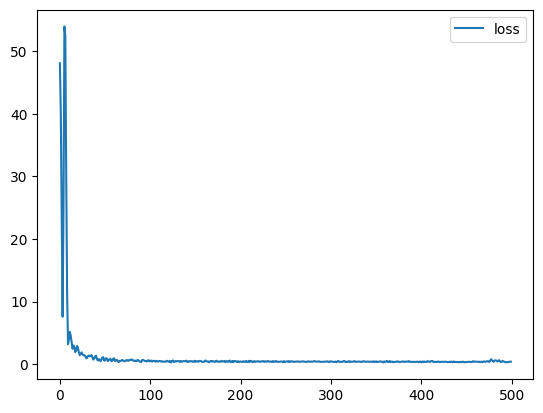

In [73]:
from IPython.display import clear_output

epochs = 100
opt = torch.optim.Adam(model.parameters(), lr=0.02)
criterion = nn.MSELoss().to(device)

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train, batch_size=800):

        batch_tensors = {key: torch.tensor(value, dtype=torch.float32, device=device) for key, value in batch.items()}
        target = torch.tensor(target, dtype=torch.float32, device=device)

        predictions = model(batch_tensors)
        predictions = predictions.flatten()

        loss = criterion(predictions, target)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [74]:
data_test = pd.concat([X_test, y_test], axis=1)
data_test = data_test.dropna()
test_features, test_target = next(iterate_minibatches(data_test, batch_size=len(data_test)))

test_batch_tensors = {key: torch.tensor(value, dtype=torch.float32, device=device) for key, value in test_features.items()}
test_target = torch.tensor(test_target, dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    test_predictions = model(test_batch_tensors)
    test_predictions = test_predictions.flatten()

test_loss = criterion(test_predictions, test_target).item()

print(f'Test MSE Loss: {test_loss}')

Test MSE Loss: 0.3401038348674774


Получилось неплохо, примерно как у Катбуста. Попробуем подобрать гиперпараметры с помощью Оптуны.

In [75]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('lr', 0.001, 0.05, log=True),
        'batch_size': trial.suggest_int('batch_size', 500, 1000, step=100),
        'epochs': trial.suggest_int('epochs', 70, 250, step=10),
    }
    model = Net()
    model.to(device)

    epochs = params['epochs']
    opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss().to(device)
    
    for epoch in range(epochs):
        for batch, target in iterate_minibatches(data_train, batch_size=params['batch_size']):

            batch_tensors = {key: torch.tensor(value, dtype=torch.float32, device=device) for key, value in batch.items()}
            target = torch.tensor(target, dtype=torch.float32, device=device)

            predictions = model(batch_tensors)
            predictions = predictions.flatten()

            loss = criterion(predictions, target)

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()

    data_test = pd.concat([X_test, y_test], axis=1)
    data_test = data_test.dropna()
    test_features, test_target = next(iterate_minibatches(data_test, batch_size=len(data_test)))

    test_batch_tensors = {key: torch.tensor(value, dtype=torch.float32, device=device) for key, value in test_features.items()}
    test_target = torch.tensor(test_target, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        test_predictions = model(test_batch_tensors)
        test_predictions = test_predictions.flatten()

    test_loss = criterion(test_predictions, test_target).item()
    
    return test_loss

In [76]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=9, n_jobs=3)

[I 2024-06-08 21:01:32,860] A new study created in memory with name: no-name-f0aa0d00-30c5-4245-9151-f4d63f80c088
[I 2024-06-08 21:01:55,981] Trial 1 finished with value: 0.35370463132858276 and parameters: {'lr': 0.004974489621027011, 'batch_size': 1000, 'epochs': 200}. Best is trial 1 with value: 0.35370463132858276.
[I 2024-06-08 21:02:03,259] Trial 2 finished with value: 0.34689804911613464 and parameters: {'lr': 0.013373626205283111, 'batch_size': 600, 'epochs': 160}. Best is trial 2 with value: 0.34689804911613464.
[I 2024-06-08 21:02:08,514] Trial 3 finished with value: 0.3537554144859314 and parameters: {'lr': 0.0042923011250387035, 'batch_size': 700, 'epochs': 80}. Best is trial 2 with value: 0.34689804911613464.
[I 2024-06-08 21:02:18,812] Trial 0 finished with value: 0.3381240665912628 and parameters: {'lr': 0.03845263282580207, 'batch_size': 600, 'epochs': 240}. Best is trial 0 with value: 0.3381240665912628.
[I 2024-06-08 21:02:19,743] Trial 5 finished with value: 0.381836

Видим, что у модели получается в среднем примерно также, как и у Катбуста - ошибка не падает ниже 0.3. Это, конечно, печально, думаю, это связано с недостатком признаков для нашей модели.

## 5. Небольшой вывод

Спасибо за то, что прочитали мой проект! Надеюсь, Вам было интересно. По итогам проекта я сделала следующие выводы: многие характеристики фильма действительно влияют на мнение зрителей о нем. Но часто от этих признаков оценка фильма может зависеть по-разному (как в положительную, так и в отрицательную сторону), а также не стоит забывать о том, что многие вещи, не поддающиеся описанию, влияют на оценку зрителей (напр. сюжет фильма), поэтому однозначно установить влияние тех или иных характеристик на рейтинг фильма сложно, в том числе и предсказывать эти оценки. В любом случае, мне было интересно выполнять проект и я узнала много нового.